# Install required packages for Google Colab

Install TensorFlow Addons for AdamW.

In [1]:
# Install TFA which contains the AdamW optimizer
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


Install the transformers package from Hugging Face for loading BERT.

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.3 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 596 kB 82.0 MB/s 
     |████████████████████████████████| 6.6 MB 80.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# Restart runtime
exit()

# Mount Google Drive and copy data
The files are located in my Google Drive folder. Using the *drive* library, my Google Driver folder is mounted, and the *hate speech dataset* is copied to the local folder of the Colab VM Machine.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Copy files from drive to local machine
!cp -r /content/drive/MyDrive/Colab_Notebooks/hate-speech-dataset-master/ /content/data

# Change to folder
%cd /content/data
%ls /content/data

Mounted at /content/drive
/content/data
annotations_metadata.csv  sampled_test/  sampled_train/


# Import the libraries

In [2]:
# OS for file management
import os
# For data handling and EDA
import pandas as pd
import numpy as np
# For Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# For text pre-processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# For NLP and ML
# Scikit-Learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.svm import LinearSVC
# Keras libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, TextVectorization
from keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_addons
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from gensim.models import KeyedVectors
# For Bert
from transformers import BertTokenizer
from transformers import TFBertModel
import torch
#Set random seeds
import random
seed_value = 5
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
torch.manual_seed(seed_value)

# Using the whole dataset
SKIP FOR NOW

## Load the whole dataset to Pandas

In [ ]:
# Load the annotations metadata csv to get label info
annot = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot['message']=''
# Loop through all lines
for i in range(len(annot['file_id'])):
    # Get current filename
    filename = annot['file_id'][i]
    # Open the file and read the contents
    with open('hate-speech-dataset-master/all_files/' +filename +'.txt') as f:
        contents= f.read()
    f.close()
    # Add contents to the message column
    annot['message'][i]=contents
# Drop file id
annot.drop(columns=['file_id'],inplace=True)

### EDA and Pre-Processing

In [ ]:
# DataFrame information
annot.info()

In [ ]:
# Check the classes and their value counts
annot['label'].value_counts()

Based on the original paper, there are a total of 10944 sentences, 9507 of them are classified as no hate speech, 1196 are classified as hate speech, 168 are related to hate speech but depends on context of the forum post and 73 are non English sentences, classified as idk/skip. For the purpose of this research, relation and idk/skip classes will be dropped completely in order to make the problem a binary classification.

In [ ]:
# Keep sentences classified only as noHate and hate
cleanPosts = annot[(annot['label'] != 'relation') & (annot['label'] != 'idk/skip')]
# Reset index
cleanPosts=cleanPosts.reset_index(drop=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Update STOPWORDS
stop_words = STOPWORDS.update(["https", "S"])

In [ ]:
# WordCloud for posts classified as hate
wc_hate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for posts classified as noHate
wc_noHate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate)
plt.axis("off")
plt.show()

### Pre-Process text with SpaCy

Before I proceed with the Bag of Words model, I need to pre-process the text (remove punctuations, stop words, lemmatize) in order to reduce the vocabulary size. I will use SpaCy for text pre-processing.

In [ ]:
# Get English words from NLTK
#nltk.download('words')
#words = set(nltk.corpus.words.words())
# Instantiate SpaCy's English module
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts['clean_message'] = cleanPosts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
                 #and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts.drop(columns='message', inplace=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Check for empty strings and remove
cleanPosts[cleanPosts['clean_message'] == ''].count()

There are 233 empty entries after lemmatization and removing stop words, which I am going to remove.

In [ ]:
# Drop rows where 'clean_message' is an empty string
# Get index
idx = cleanPosts[cleanPosts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts.drop(index=idx, inplace=True)

In [ ]:
# WordCloud for cleaned posts classified as hate
wc_hate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_clean)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for cleaned posts classified as noHate
wc_noHate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_clean)
plt.axis("off")
plt.show()

In [ ]:
# Plot the class distribution
plot = cleanPosts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

## Recreating Paper Results

### Support Vector Machines

#### Bag-of-Words Vectors

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Vectorize
X = vectorizer.fit_transform(cleanPosts.clean_message.to_list())
X_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

#### Split Dataset for SVM Model

In [ ]:
# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, cleanPosts.label, test_size=0.25, random_state=42, stratify=cleanPosts.label)

#### Classify text using SVM Model

Train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train, y_train)
# Get prediction on test data
pred = svm.predict(X_test)

#### Get Accuracy and Confusion Matrix

In [ ]:
# Get the accuracy
print('Test Accuracy: '+str(svm.score(X_test, y_test)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test, pred, pos_label='hate')))
# Create confusion matrix
cm = confusion_matrix(y_test, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using all the available txt files with text pre-processing on a SVM Model returned an accuracy of 0.87 but an F1 Score of 0.48. This is because there is a big class inbalance in the training data. The SVM model does a really good job at classifying correctly the noHate sentences but handles poorly the hate sentences since more than half of them are missclassified.

# Using the sampled train and test dataset
The experiments of this research will be based on a balanced subset of labelled sentences, which is already provided by the dataset owner in the *sampled_train* and *sampled_test* folders. According to the dataset owner, "All the sentences labelled as **hate** have been collected, and an equivalent number of **noHate** sentences have been randomly sampled, summing up 2k labelled sentences. From this amount, 80% has been used for training and the remaining 20% for testing." Each sentence is saved as a separate text file.

## Load the provided sampled_train and sampled_test dataset from txt files
The *annotations_metadata.csv* file contains the label information of each text file name, and will be used to load and map the sentences with their labels. The text files will be loaded into two Pandas DataFrames, one for the training data and one for the test data.

**Load the *annotations_metadata* file into a Pandas DataFrame and view the first five rows.**

In [3]:
# Load the annotations metadata csv to a pandas dataframe
annot_df = pd.read_csv("annotations_metadata.csv")
# View the first five rows
annot_df.head(5)

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


The DataFrame has five columns: file_id (the name of the text file), user_id (the unique ID of the user that created the forum post), subforum_id (the unique ID of the forum each sentence belongs to), num_contexts (sentence information related to the *Relation* class), and label (the class each sentence belongs to).


**View the unique sentence labels.**

In [4]:
# View unique labels
annot_df.label.unique()

array(['noHate', 'hate', 'idk/skip', 'relation'], dtype=object)

The sentences are classified into four unique labels: *noHate* (the sentence does not contain hate speech content), *hate* (the sentence contains hate speech content), *idk/skip* (non-English sentences), and *relation* (sentences that belong in a forum post that contains other hate speech sentences).

This research will experiment on a binary classification problem, predicting if a sentence is *Hate Speech* or *No Hate Speech*, therefore rows with *idk/skip* and *relation* labels can be dropped. Also, the columns *user_id, subforum_id,* and *num_contexts* can also be dropped, since only the *file_id* and *label* columns are required. A new column named *sentence* will be created that will contain the sentences' contents.

**Drop rows with *idk/skip* and *relation labels*.**

In [5]:
# Keep sentences classified only as noHate and hate
annot_df = annot_df[(annot_df['label'] != 'relation') & (annot_df['label'] != 'idk/skip')]
# Reset index
annot_df = annot_df.reset_index(drop=True)

**Drop the columns *user_id, subforum_id,* and *num_contexts* and create new column *sentence*.**

In [6]:
# Keep only the columns file id and label
annot_df.drop(columns=['user_id','subforum_id','num_contexts'], inplace=True)
# Add new empty column to insert the message
annot_df['sentence']=''

**Load the sampled train and test text files from their corresponding folder.**

In [7]:
# Load the sampled_train txt files
# Create a copy of the annotation dataframe, train_df
train_df = annot_df.copy()
# Loop through all rows (for every filename)
for i in range(len(train_df['file_id'])):
    # Get current filename
    filename = train_df['file_id'][i]
    try: # Use try because we load from a subset of all text files
        # Open the file and read the contents
        with open('sampled_train/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents of the current file to the sentence column
        train_df['sentence'][i]=contents
    except: # If the file is not in the folder
        pass # Move to the next filename

# Load the sampled_test txt files
# Create a copy of the annotation dataframe, test_df
test_df = annot_df.copy()
# Loop through all rows (for every filename)
for i in range(len(test_df['file_id'])):
    # Get current filename
    filename = test_df['file_id'][i]
    try: # Use try because we load from a subset of all text files
        # Open the file and read the contents
        with open('sampled_test/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents of the current file to the sentence column
        test_df['sentence'][i]=contents
    except: # If the file is not in the folder
        pass # Move to the next filename

**Drop *file_id* column and rows where the *sentence* is an empty string.**

In [8]:
# Drop file id since it's not required anymore
train_df.drop(columns=['file_id'],inplace=True) # Train DataFrame
test_df.drop(columns=['file_id'],inplace=True) # Test DataFrame

# Drop rows where 'sentence' is an empty string - Train DataFrame
# Get index
idx = train_df[train_df['sentence'] == ''].index
# Drop rows based on index
train_df.drop(index=idx, inplace=True)

# Drop rows where 'sentence' is an empty string - Test DataFrame
# Get index
idx = test_df[test_df['sentence'] == ''].index
# Drop rows based on index
test_df.drop(index=idx, inplace=True)

# Reset index
train_df = train_df.reset_index(drop=True) # Train DataFrame
test_df = test_df.reset_index(drop=True) # Test DataFrame

### EDA and Text Pre-Processing

#### WordCloud - Train Data

**Sentences Classified as Hate Speech**

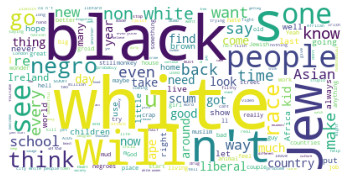

In [9]:
# WordCloud for sentences classified as hate
wc_hate_tr = WordCloud(background_color='white').generate(' '.join(train_df['sentence'][train_df['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tr)
plt.axis("off")
plt.show()

**Sentences Classified as no Hate Speech**

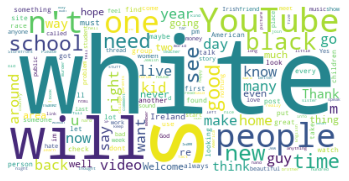

In [10]:
# WordCloud for sentences classified as noHate
wc_noHate_tr = WordCloud(background_color='white').generate(' '.join(train_df['sentence'][train_df['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tr)
plt.axis("off")
plt.show()

#### WordCloud - Test Data

**Sentences Classified as Hate Speech**

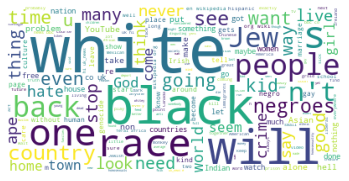

In [11]:
# WordCloud for sentences classified as hate
wc_hate_tst = WordCloud(background_color='white').generate(' '.join(test_df['sentence'][test_df['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tst)
plt.axis("off")
plt.show()

**Sentences Classified as no Hate Speech**

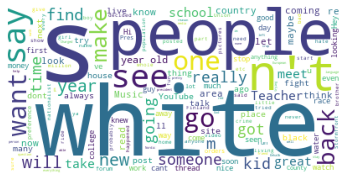

In [12]:
# WordCloud for sentences classified as noHate
wc_noHate_tst = WordCloud(background_color='white').generate(' '.join(test_df['sentence'][test_df['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tst)
plt.axis("off")
plt.show()

The above WordClouds show the most common words found in sentences classified as Hate Speech and No Hate Speech, with both train and test subsets having similar results. 

Words like "black", "white", "Jew", "Asian", "negro", "race", "ape", are few of the most common words found in the WordCloud of Hate Sentences, words that are often found in hate speech language. On the other hand, while words like "black" or "white" also appear in the WordCloud of No Hate Sentences, we can assume that their meaning is not hate speech related, as there are among other seemingly "innocent" words like "YouTube", "shool", "people", "time", "good" and others.

#### Plot class distribution

**Train Subset**

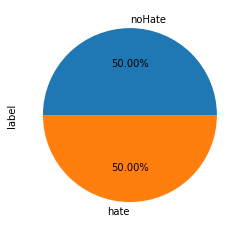

In [13]:
# Plot the class distribution - Train
plot_tr = train_df.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

**Test Subset**

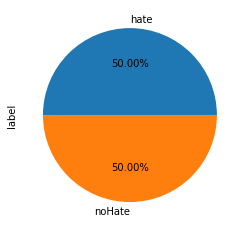

In [14]:
# Plot the class distribution - Test
plot_tst = test_df.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Text Pre-Processing using NLTK
According to their published paper, the owners of the dataset conducted their experimentations without doing any heavy text pre-processing on the sentences. In order to recreate their paper results, a similar approach will be taken, applying only very basic pre-processing on the sentences, like lowercasing and removing punctuation and non-alpha character.

A new "clean_sentence" column will be created for both train and test subsets, containing each processed sentence, using nltk and applying a lambda function to the "sentence" column.

In [15]:
nltk.download('punkt') # NLTK resources for removing punctuation
#nltk.download('stopwords') # NLTK resources for removing stopwords
#stop_words = set(stopwords.words('english')) # set English stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Pre-Process the train subset**

In [16]:
# Train Subset
# Create new column and apply pre-processing using nltk
train_df['clean_sentence'] = train_df.sentence.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)

**Pre-Process the test subset**

In [17]:
# Test Subset
# Create new column and apply pre-processing using nltk
test_df['clean_sentence'] = test_df.sentence.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)

**Drop rows where the *clean_sentence* is an empty string**

In [18]:
# Drop rows where 'sentence' is an empty string - Train DataFrame
# Get index
idx = train_df[train_df['clean_sentence'] == ''].index
# Drop rows based on index
train_df.drop(index=idx, inplace=True)

# Drop rows where 'sentence' is an empty string - Test DataFrame
# Get index
idx = test_df[test_df['clean_sentence'] == ''].index
# Drop rows based on index
test_df.drop(index=idx, inplace=True)

# Reset index
train_df = train_df.reset_index(drop=True) # Train DataFrame
test_df = test_df.reset_index(drop=True) # Test DataFrame

## Recreating Paper Results
The purpose of this section is to attempt to recreate the results reported in the dataset owners' paper, in order to use them as a benchmarking tool and compare them with the results of this research.

In the paper, the below three algorithms were used for Hate Speech Classification:

- Support Vector Machines (SVM) over Bag-of-Words vectors. Word-count-based vectors were computed and fed into a Python Scikit-learn LinearSVM classifier to separate Hate and NoHate instances
- Convolutional Neural Networks (CNN). The implementation was a simplified version using a single input channel of randomly initialized word embeddings
- Recurrent Neural Networks with Long Short-term Memory (LSTM). A LSTM layer of size 128 over word embeddings of size 300

All the hyperparameters were left to the usual values reported in the literature. No hyperparameter tuning was performed. A more comprehensive experimentation and research was left for future work.

### Support Vector Machine (SVM)

#### Bag-of-Words Vectors
Bag-of-words is a simple word representation model that creates fixed-sized vectors from arbitrary text. This is done by defining a vocabulary, a set of all words found in the given documents and counting how many times each word appears. The general idea of bag-of-words in a linguistic context can be found in (Harris, 1954). Although bag-of-words is a relatively basic model, it is widely used for text classification tasks due to its simplicity and how inexpensive to compute it is.

For the creation of the Bag-of-Words model, CountVectorizer will be used. The first step is to create the vocabulary, which will be created using only the train subset, in order to avoid leaking the test data to the SVM model.

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()

# Create the vocabulary using the train subset
vectorizer.fit(train_df.clean_sentence.to_list())

# Transform train sample to document-term matrix
X_train_mat = vectorizer.transform(train_df.clean_sentence.to_list())
# Create a Pandas DataFrame from the document-term matrix
X_train_df = pd.DataFrame(X_train_mat.toarray(), columns=vectorizer.get_feature_names_out())

# Transform test sample to document-term matrix
X_test_mat = vectorizer.transform(test_df.clean_sentence.to_list())
# Create a dataframe from the document-term matrix
X_test_df = pd.DataFrame(X_test_mat.toarray(),columns=vectorizer.get_feature_names_out())

#### Create and train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train_df, train_df.label)
# Get prediction on test data
svm_pred = svm.predict(X_test_df)

#### Get Accuracy, F1 Score and Confusion Matrix

Accuracy: 0.7305263157894737
F1 Score: 0.7288135593220338


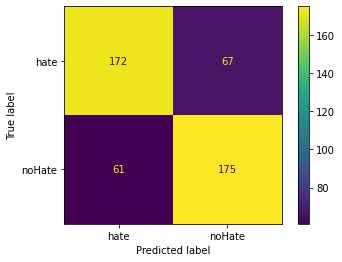

In [ ]:
# Print the accuracy
print('Accuracy: '+str(svm.score(X_test_df, test_df.label)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(test_df.label, svm_pred, pos_label='hate')))
# Create confusion matrix
cm = confusion_matrix(test_df.label, svm_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using the sampled train and test data returned an accuracy of 0.73, which is lower than the accuracy I got using the whole dataset. However, the F1 Score is much higher, 0.73, and the model does a fair job in correctly classifying both hate and noHate classes. These results are very close to the results from the paper and indicate the importance of having a class balanced dataset in text classification problems. As a result, the balanced train and test subsets will be used for the rest of the experimentations.

### Convolutional Neural Network (CNN)

In their paper, the owners of the dataset have provided a github repository which includes code for a slightly simplified implementation of Kim's Convolutional Neural Networks for Sentence Classification paper, CNN-rand, written in Tensorflow.

The code below is my implementation of the above, written in Keras.

#### Dataset Preparation
The dataset needs to be prepared before it is used on the CNN Model. First, a vocabulary needs to be created to tokenize the text into number sequences. Second, all sequences must be padded to the same length. Finally, the train and test subset labels have to be one hot encoded.

The max sentence length is 323


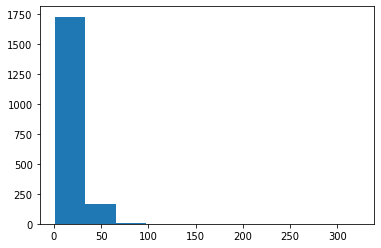

In [ ]:
# Get the length of all sentences
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Histogram on the sentences length
len_hist=plt.hist(sent_len)
# Print the max sentence length
print('The max sentence length is '+ str(max(sent_len)))

It is common practice to pad all sentences to the max sentence length. However, the above histogram shows that the vast majority of sentences have a length between 0 and 50, with a few sentences going up to 100. Therefore, the max sentence length that will be used for applying padding, will be 150.

In [ ]:
# Set max sentence length to 150
max_sent_len = 150
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to True
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

# Convert train subset to list of sequences
X_train_cnn = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_cnn = pad_sequences(X_train_cnn, maxlen=max_sent_len, dtype='float32',
                            padding='pre')

# Convert test to sequences
X_test_cnn = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_cnn = pad_sequences(X_test_cnn, maxlen=max_sent_len, dtype='float32',
                           padding='pre')

# one hot encode train labels
y_train_cnn = pd.get_dummies(train_df.label).values.astype('float32')

# one hot encode test labels
y_test_cnn = pd.get_dummies(test_df.label).values.astype('float32')

#### Set up hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The size of the embedding layer (Output dimension)
embedding_dim = 200
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 200

#### Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_cnn.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = len(tokenizer.word_index) + 1 # The input dimension of the embedding layer 
num_classes = y_train_cnn.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with randomly initialized word embeddings
embLayer = Embedding(vocab_size, embedding_dim,embeddings_initializer='random_uniform',
                     input_length=sequence_length, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_model.summary()

Sequence Length: 150
Input Shape: (150,)
Vocabulary Size: 5549
Embedding Size: 200
Number of Classes: 2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 150, 200)     1109800     ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 150, 200)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 148, 100)     60100       ['DropoutLayer1[0][0]'] 

The Neural Network uses an input layer, one embedding layer of randomly initialized word embeddings, one dropout layer to avoid overfitting. Three pairs of Convolution and Pooling layers, one for each kernel size of 3, 4 and 5, are used to capture the semantic patterns of each sentence, which are then concatenated together. Finally, a second dropout layer is added followed by a dense output layer that classifies each sentence.

#### Visualise the CNN Model
The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

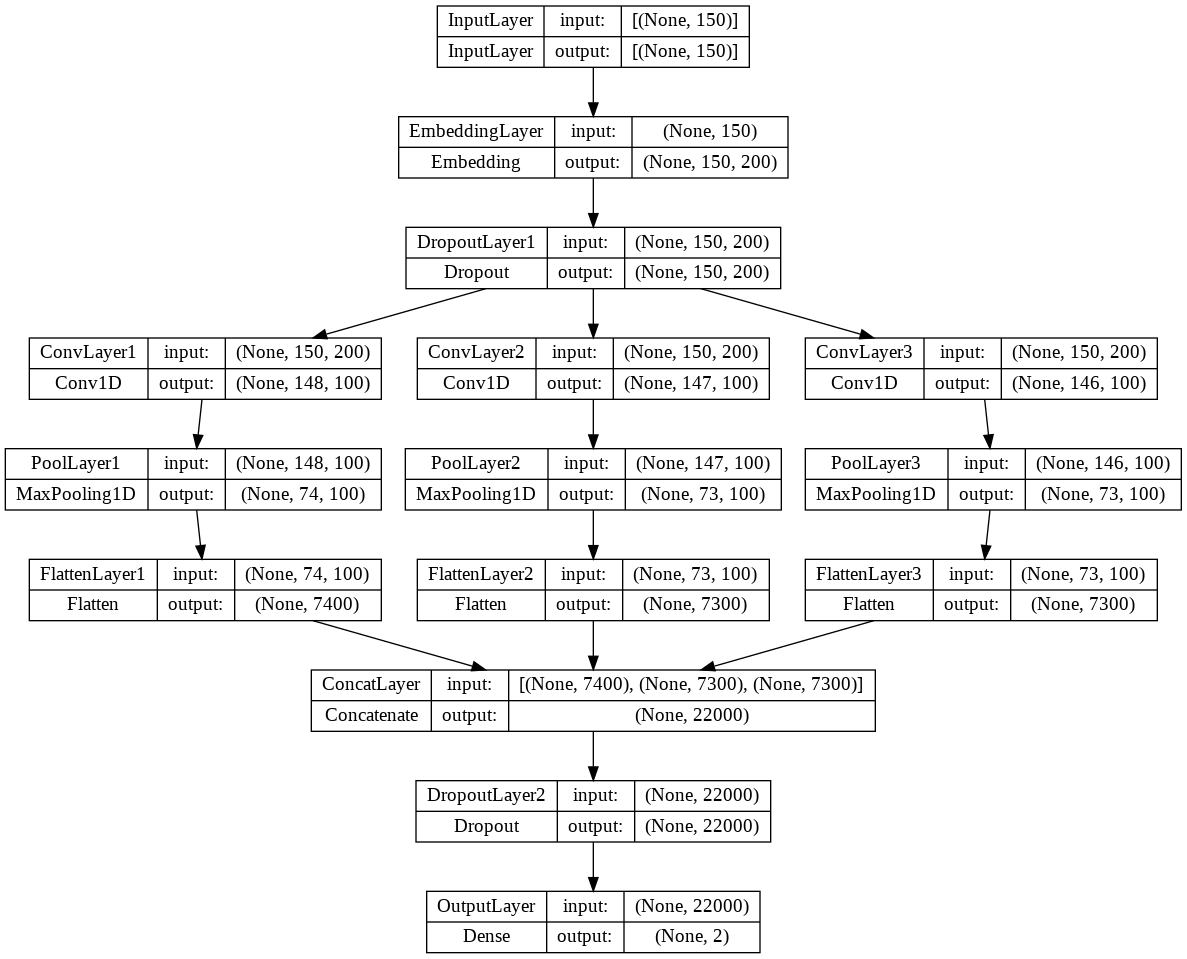

In [ ]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

#### Train the CNN Model
The model gets compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

**Set up a Learning Rate Scheduler**

The idea is that a higher learning rate will be used first to avoid getting "stuck" at a local minima which will then start decaying exponentially in order to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_cnn.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.00005 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

**Train the Model**

In [ ]:
# Specify optimizer, loss function, and performance metrics
cnn_model.compile(optimizer=Adam(learning_rate = lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/200
27/27 [==============================] - 11s 25ms/step - loss: 0.6947 - acc: 0.5149 - val_loss: 0.6891 - val_acc: 0.4869
Epoch 2/200
27/27 [==============================] - 0s 13ms/step - loss: 0.6875 - acc: 0.5365 - val_loss: 0.6831 - val_acc: 0.5812
Epoch 3/200
27/27 [==============================] - 0s 12ms/step - loss: 0.6799 - acc: 0.5809 - val_loss: 0.6787 - val_acc: 0.5969
Epoch 4/200
27/27 [==============================] - 0s 13ms/step - loss: 0.6745 - acc: 0.6071 - val_loss: 0.6744 - val_acc: 0.6021
Epoch 5/200
27/27 [==============================] - 0s 12ms/step - loss: 0.6702 - acc: 0.6159 - val_loss: 0.6700 - val_acc: 0.6178
Epoch 6/200
27/27 [==============================] - 0s 13ms/step - loss: 0.6635 - acc: 0.6299 - val_loss: 0.6654 - val_acc: 0.6021
Epoch 7/200
27/27 [==============================] - 0s 12ms/step - loss: 0.6585 - acc: 0.6451 - val_loss: 0.6609 - val_acc: 0.5969
Epoch 8/200
27/27 [==============================] - 0s 12ms/step - loss: 0

#### Plot the model's training history
Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
cnn_hist_dict = cnn_history.history
# Store the performance metrics
cnn_acc = cnn_hist_dict['acc'] # Accuracy
cnn_val_acc = cnn_hist_dict['val_acc'] # Validation Accuracy
cnn_loss = cnn_hist_dict['loss'] # Loss
cnn_val_loss = cnn_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_acc) + 1)

**Plot training and validation loss**

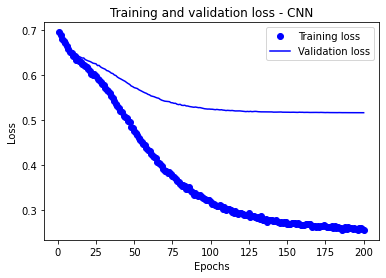

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

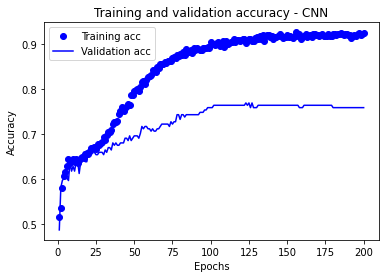

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

#### Test the CNN model
The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 4ms/step - loss: 0.5713 - acc: 0.7137
Model Loss, Model Accuracy: [0.5713062286376953, 0.7136842012405396]
15/15 [==============================] - 0s 2ms/step
F1 Score: 0.7433962264150945


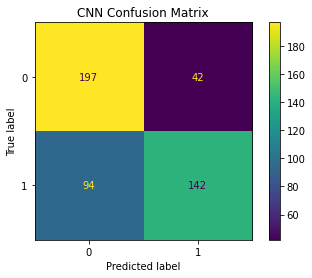

In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
cnn_results = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print("Model Loss, Model Accuracy:", cnn_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
cnn_pred = cnn_model.predict(X_test_cnn)
# Convert pred to boolean
y_pred_bool = np.argmax(cnn_pred, axis=1)
# Convert the categorical label to numeric
y_test_cnn_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_cnn_num, y_pred_bool, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_cnn_num, y_pred_bool) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('CNN Confusion Matrix') # Set Title
# Show the plot
plt.show()

The CNN model's overall results are slightly better than the paper's reported results, when including data with sentences that required additional context for manual annotation. The performance is slightly worse when it comes to classifying No Hate sentences. However, the model does a much better job in correctly classifying Hate sentences, having an overall accuracy of 0.73, compared to 0.70 reported in the paper.

A possible explanation for this deviation could be the different type of pre-processing that was applied or the lack of it.


### Long Short-Term Memory (LSTM)

#### Dataset Preparation
Similarly to the CNN steps, the dataset needs to be prepared before it is used on the LSTM Model. There is an important difference in regards to sequence padding. Initially, post-padding was used, similarly to the CNN model. However, the LSTM performance was negatively affected, classifying all sentences into the *hate* class only, returning an accuracy of 50%. The LSTM model works only with pre-padding, since post-padding adds noise to the sequences, preventing the model from learning. 

The max sentence length is 323


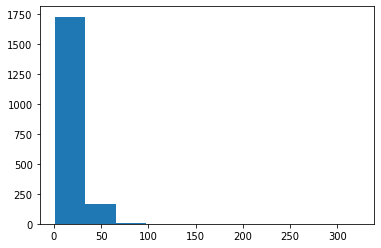

In [ ]:
# Get the length of all sentences
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Histogram on the sentences length
len_hist=plt.hist(sent_len)
# Print the max sentence length
print('The max sentence length is '+ str(max(sent_len)))

It is common practice to pad all sentences to the max sentence length. However, the above histogram shows that the vast majority of sentences have a length between 0 and 50, with a few sentences going up to 100. Therefore, the max sentence length that will be used for applying padding, will be 150.

In [ ]:
# Set max sentence length to 150
max_sent_len = 150
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to True
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

# Convert train subset to list of sequences
X_train_lstm = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_lstm = pad_sequences(X_train_lstm, maxlen=max_sent_len, dtype='float32',
                            padding='pre')

# Convert test to sequences
X_test_lstm = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_lstm = pad_sequences(X_test_lstm, maxlen=max_sent_len, dtype='float32',
                           padding='pre')

# one hot encode train labels
y_train_lstm = pd.get_dummies(train_df.label).values.astype('float32')

# one hot encode test labels
y_test_lstm = pd.get_dummies(test_df.label).values.astype('float32')

#### Set up hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The size of the embedding layer (Output dimension)
embedding_dim = 300
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 200

#### Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_lstm.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = len(tokenizer.word_index) + 1 # The input dimension of the embedding layer 
num_classes = y_train_lstm.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with randomly initialized word embeddings
embLayer = Embedding(vocab_size, embedding_dim, embeddings_initializer='random_uniform',
                     input_length=sequence_length,name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_model.summary()

Sequence Length: 150
Input Shape: (150,)
Vocabulary Size: 5549
Embedding Size: 300
Number of Classes: 2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 150)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 150, 300)          1664700   
                                                                 
 DropoutLayer1 (Dropout)     (None, 150, 300)          0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               219648    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                     

#### Visualise the LSTM Model
The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

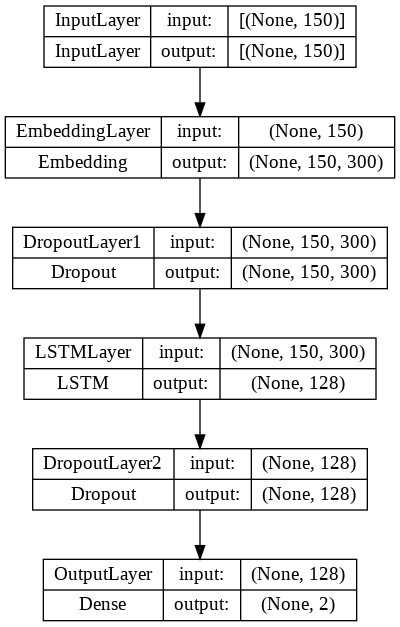

In [ ]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

#### Train the LSTM Model
The model gets compiled choosing Adam as the preferred optimize rwith a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

**Set up a Learning Rate Scheduler**

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minima which will then start decaying exponentially in order to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_lstm.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.00003 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

**Train the Model**

In [ ]:
# Specify loss function, optimizer, and performance metrics
lstm_model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/200
27/27 [==============================] - 4s 38ms/step - loss: 0.6911 - acc: 0.5342 - val_loss: 0.6905 - val_acc: 0.5288
Epoch 2/200
27/27 [==============================] - 0s 15ms/step - loss: 0.6878 - acc: 0.5674 - val_loss: 0.6871 - val_acc: 0.5969
Epoch 3/200
27/27 [==============================] - 0s 15ms/step - loss: 0.6823 - acc: 0.5908 - val_loss: 0.6828 - val_acc: 0.5864
Epoch 4/200
27/27 [==============================] - 0s 15ms/step - loss: 0.6776 - acc: 0.6141 - val_loss: 0.6773 - val_acc: 0.5969
Epoch 5/200
27/27 [==============================] - 0s 15ms/step - loss: 0.6704 - acc: 0.6019 - val_loss: 0.6693 - val_acc: 0.5864
Epoch 6/200
27/27 [==============================] - 0s 15ms/step - loss: 0.6613 - acc: 0.6147 - val_loss: 0.6608 - val_acc: 0.5654
Epoch 7/200
27/27 [==============================] - 0s 15ms/step - loss: 0.6550 - acc: 0.6118 - val_loss: 0.6550 - val_acc: 0.5812
Epoch 8/200
27/27 [==============================] - 0s 16ms/step - loss: 0.

#### Plot the model's training history
Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
lstm_hist_dict = lstm_history.history
# Store the performance metrics
lstm_acc = lstm_hist_dict['acc'] # Accuracy
lstm_val_acc = lstm_hist_dict['val_acc'] # Validation Accuracy
lstm_loss = lstm_hist_dict['loss'] # Loss
lstm_val_loss = lstm_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_acc) + 1)

**Plot training and validation loss**

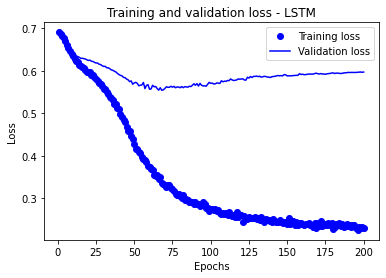

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

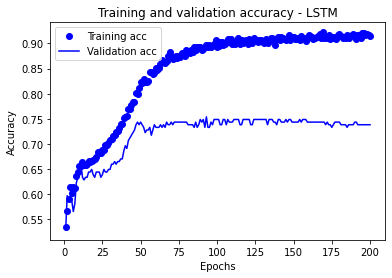

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

#### Test the LSTM model
The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 6ms/step - loss: 0.6115 - acc: 0.7411
Model Loss, Model Accuracy: [0.6114649176597595, 0.7410526275634766]
15/15 [==============================] - 1s 5ms/step
F1 Score: 0.7421383647798742


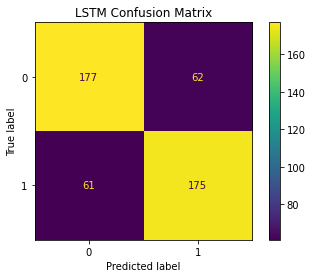

In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
lstm_results = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print("Model Loss, Model Accuracy:", lstm_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
lstm_pred = lstm_model.predict(X_test_lstm)
# Convert pred to boolean
y_pred_bool = np.argmax(lstm_pred, axis=1)
# Convert the categorical label to numeric
y_test_lstm_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_lstm_num, y_pred_bool, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_lstm_num, y_pred_bool) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('LSTM Confusion Matrix') # Set Title
# Show the plot
plt.show()

The LSTM model's performance is in line with the performance reported in the paper, when including data with sentences that required additional context for manual annotation. The model does a fair job at correctly identifying both classes, having an overall accuracy of 0.74, same as the one reported in the paper.

## Pre-Trained Word Embeddings and the Use of Context
The purpose of this research is to experiment with contextualised pre-trained word embedding models.

This section will attempt to answer the question "To what extent contextualised word embedding methods improve hate speech detection?" by introducing pre-trained word embeddings to the above models, replacing the traditional bag-of-word model used in the SVM model and the random word embeddings used in both the CNN and LSTM models.

First, the experiments will be done using context independent models (i.e. Word2vec and GloVe). The performance will then be compared with the performance of context dependent models (i.e. ELMo and BERT).

### Context Independent Word Embeddings - GloVe
The Global Vectors for Word Representation, or GloVe for short, is an unsupervised learning algorithm for obtaining vector representations for words. It was introduced in (Pennington, Socher and Manning, 2014) as an extension to the Word2Vec method. As stated by Pennington, Socher, and Manning in their paper, “The result is a new global log-bilinear regression model that combines the advantages of the two major model families in the literature: global matrix factorization and local context window methods”. GloVe maps words into a meaningful vector space where the distance between words is related to semantic similarity (Abad et al., 2016). According to the original paper, it outperforms other models on word analogy, word similarity, and named entity recognition tasks.

The below implementation was inspired by the Keras tutorial on pre-trained embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/

#### Create a vocabulary index

The first step is to index the vocabulary found in the dataset, by using Keras' Tokenizer.

In [383]:
# Set max sentence length to 150
max_sent_len = 150
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to True
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

Get a dictionary with each word to its index.

In [384]:
# Get word index
word_idx = tokenizer.word_index

Checking that the dictionary works, using a test sentence. 

In [385]:
test = ["i", "like", "every", "person", "in", "the", "world"]
[word_idx[w] for w in test]

[6, 32, 95, 164, 8, 2, 147]

#### Load the GloVe pre-trained word embeddings

Download the GloVe word embeddings and use the 200-dimensional vectors to create a dictionary mapping each word to its NumPy vector representation.

In [386]:
# Download glove embeddings
#!wget http://nlp.stanford.edu/data/glove.6B.zip

# Copy glove file from drive to local machine
!cp -r /content/drive/MyDrive/Colab_Notebooks/glove.6B.zip /content/data
!unzip -q glove.6B.zip # Unzip

In [387]:
# Create the dictionary mapping words to vector representations
# Create an empty dictionary
emb_idx = {}
# Open glove text file 
with open('glove.6B.200d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # get word and vector coefs
        coefs = np.fromstring(coefs, "f", sep=" ") # transform to numpy array
        emb_idx[word] = coefs # store word and array of coefs to the dictionary

The next step is to create a corresponding embedding matrix that can be used in the Keras Embedding layer. Entry at index i is the pre-trained vector for the word of index i in the vectorizer's vocabulary.

In [388]:
# Embedding matrix for keras embedding layer
embedding_dim = 200 # dimension of glove vectors used
num_tokens = len(word_idx) + 1

# Create the embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# Go through every word in the word/idx dictionary
for word, i in word_idx.items():
    # Get word's vector representation from the emb dictionary
    embedding_vector = emb_idx.get(word)
    # If vector is not none (the word exists)
    if embedding_vector is not None:
        # Store word's index and its vector representation
        embedding_matrix[i] = embedding_vector
    else:
        pass

Check how many words from the vocabulary are not found in the pre-trained vectors.

In [389]:
# Counter for missing words
missing_words = 0
# For every word_vector in the matrix
for word_vector in embedding_matrix:
  # If the mean is zero
  if word_vector.mean() == 0:
    missing_words+=1 # Counter
# Show number of missing words minus 1 for the OOV token
print(str(missing_words - 1) + " words from the vocabulary are missing from the Pre-Trained GloVe vectors.")

313 words from the vocabulary are missing from the Pre-Trained GloVe vectors.


The matrix can now be loaded into a Keras Embedding layer, with the trainable flag equal to False, so that it won't get updated during the training.

#### Prepare the train and test subsets for training

First, the list-of-strings data must be converted to NumPy arrays of integer indices.

In [390]:
# Convert train subset to list of sequences
X_train_glv = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_glv = pad_sequences(X_train_glv, maxlen=max_sent_len, dtype='int64',
                            padding='pre')

# Convert test to sequences
X_test_glv = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_glv = pad_sequences(X_test_glv, maxlen=max_sent_len, dtype='int64',
                           padding='pre')



# one hot encode train labels
y_train_glv = pd.get_dummies(train_df.label).values.astype('int64')
# Convert the categorical label to numeric
y_train_glv_num = train_df.label.replace(['hate','noHate'],[0,1])

# one hot encode test labels
y_test_glv = pd.get_dummies(test_df.label).values.astype('int64')
# Convert the categorical label to numeric
y_test_glv_num = test_df.label.replace(['hate','noHate'],[0,1])

#### Test the Support Vector Machine Model with the GloVe embeddings

**Map the embedding matrix vectors to the train and test data**

Unlike the Keras Deep Learning Networks, the Scikit-learn LinearSVC model does not incorporate an embedding layer. Therefore, the mapping to the train and test data has to be applied manually.

In [391]:
# Initialize empty lists for train and test data
X_train_svm_glv = []
X_test_svm_glv = []

# Map embedding matrix to the train subset
for sent_array in X_train_glv: # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_train_svm_glv.append(temp_list)
# Transform to numpy array
X_train_svm_glv = np.asarray(X_train_svm_glv, dtype='float64')
# Reshape from 3D to 2D to feed in SVM
X_train_svm_glv = X_train_svm_glv.reshape(X_train_glv.shape[-2],-1)

# Map embedding matrix to the test subset
for sent_array in X_test_glv: # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_test_svm_glv.append(temp_list)
# Transform to numpy array
X_test_svm_glv = np.asarray(X_test_svm_glv, dtype='float64')
# Reshape from 3D to 2D to feed in SVM
X_test_svm_glv = X_test_svm_glv.reshape(X_test_glv.shape[-2],-1)

Create and train the SVM model

In [ ]:
# Instatiate SVC
svm_glv = LinearSVC(C=0.0005)
# Fit training data
svm_glv.fit(X_train_svm_glv, y_train_glv_num)
# Get prediction on test data
svm_glv_pred = svm_glv.predict(X_test_svm_glv)

Get Accuracy, F1 Score, and Confusion Matrix

Accuracy: 0.7073684210526315
F1 Score: 0.7157464212678937


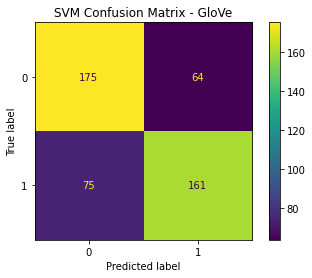

In [ ]:
# Print the accuracy
print('Accuracy: '+str(svm_glv.score(X_test_svm_glv, y_test_glv_num)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_glv_num, svm_glv_pred, pos_label=0)))
# Create confusion matrix
cm = confusion_matrix(y_test_glv_num, svm_glv_pred, labels=svm_glv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_glv.classes_)
disp.plot()
plt.title('SVM Confusion Matrix - GloVe')
plt.show()

Using GloVe embeddings with SVM negatively affected the performance slightly, compared to using the traditional Bag-of-Words method. These results make sense since simpler models like SVM, cannot handle three-dimensional data like Deep Learning Neural Networks. The embedding vectors had to be reshaped to maintain the dimensionality that works with SVM, losing the spatial features of the GloVe vectors.

#### Test the Convolutional Neural Network Model with the GloVe embeddings

Set up hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 250

Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_glv.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_glv.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with GloVe word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_glv_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_glv_model.summary()

Sequence Length: 150
Input Shape: (150,)
Vocabulary Size: 5549
Embedding Size: 200
Number of Classes: 2
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 150, 200)     1109800     ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 150, 200)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 148, 100)     60100       ['DropoutLayer1[0][0]'

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

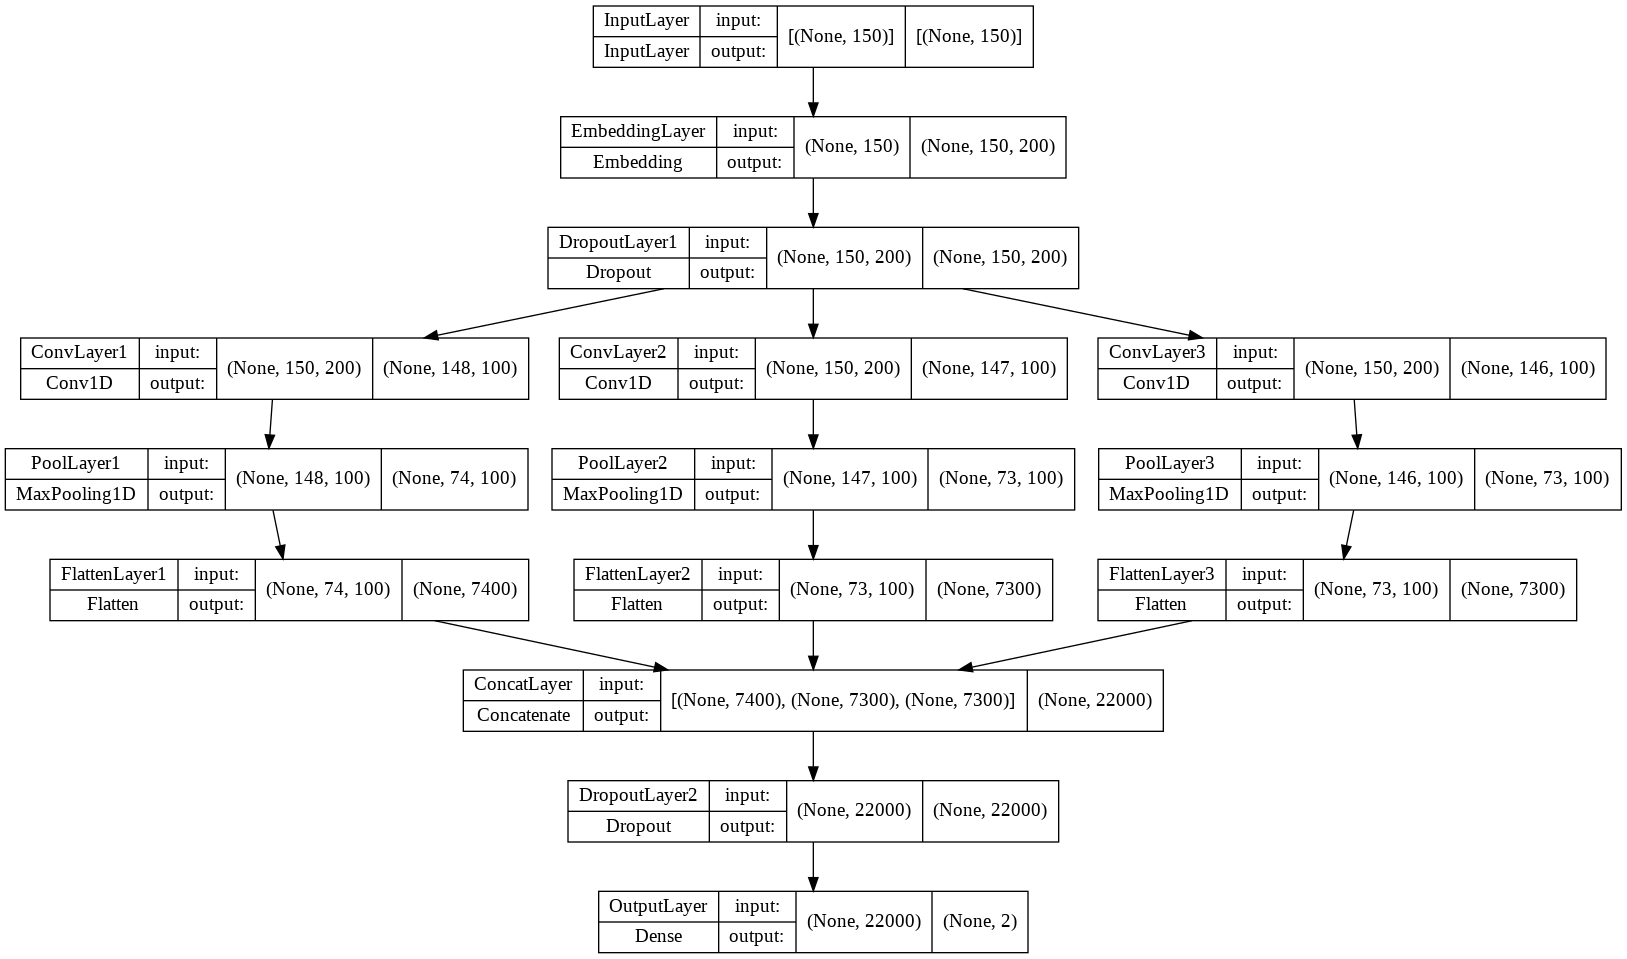

In [ ]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(cnn_glv_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the CNN Model**

The model gets compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minima which will then start decaying exponentially in order to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_glv.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.00006 # Starting learning rate
decay_rate = 0.85 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_glv_model.compile(optimizer=Adam(learning_rate = lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_glv_history = cnn_glv_model.fit(X_train_glv, y_train_glv, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/250
27/27 [==============================] - 1s 19ms/step - loss: 0.7179 - acc: 0.5055 - val_loss: 0.6805 - val_acc: 0.5550
Epoch 2/250
27/27 [==============================] - 0s 10ms/step - loss: 0.6908 - acc: 0.5844 - val_loss: 0.6618 - val_acc: 0.6230
Epoch 3/250
27/27 [==============================] - 0s 9ms/step - loss: 0.6696 - acc: 0.6077 - val_loss: 0.6550 - val_acc: 0.6283
Epoch 4/250
27/27 [==============================] - 0s 9ms/step - loss: 0.6654 - acc: 0.6241 - val_loss: 0.6491 - val_acc: 0.6335
Epoch 5/250
27/27 [==============================] - 0s 9ms/step - loss: 0.6569 - acc: 0.6299 - val_loss: 0.6448 - val_acc: 0.6440
Epoch 6/250
27/27 [==============================] - 0s 9ms/step - loss: 0.6403 - acc: 0.6521 - val_loss: 0.6379 - val_acc: 0.6283
Epoch 7/250
27/27 [==============================] - 0s 9ms/step - loss: 0.6423 - acc: 0.6468 - val_loss: 0.6341 - val_acc: 0.6492
Epoch 8/250
27/27 [==============================] - 0s 9ms/step - loss: 0.6337 -

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

Load the training and validation accuracy and loss from the training history

In [ ]:
# Load the history dictionary
cnn_glv_hist_dict = cnn_glv_history.history
# Store the performance metrics
cnn_glv_acc = cnn_glv_hist_dict['acc'] # Accuracy
cnn_glv_val_acc = cnn_glv_hist_dict['val_acc'] # Validation Accuracy
cnn_glv_loss = cnn_glv_hist_dict['loss'] # Loss
cnn_glv_val_loss = cnn_glv_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_glv_acc) + 1)

Plot training and validation loss

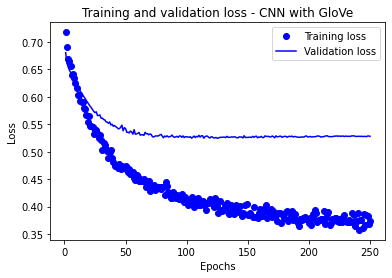

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_glv_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_glv_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

Plot training and validation accuracy

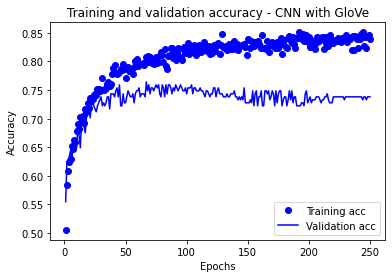

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_glv_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_glv_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 3ms/step - loss: 0.5545 - acc: 0.7179
Model Loss, Model Accuracy: [0.5545226335525513, 0.7178947329521179]
GloVe F1 Score: 0.6763285024154589


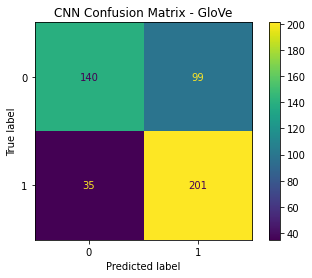

In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
cnn_glv_results = cnn_glv_model.evaluate(X_test_glv, y_test_glv)
print("Model Loss, Model Accuracy:", cnn_glv_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
cnn_glv_pred = cnn_glv_model.predict(X_test_glv)
# Convert pred to boolean
y_pred_bool_glv = np.argmax(cnn_glv_pred, axis=1)
# Convert the categorical label to numeric
y_test_cnn_glv_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('GloVe F1 Score: '+str(f1_score(y_test_cnn_glv_num, y_pred_bool_glv, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_cnn_glv_num, y_pred_bool_glv) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('CNN Confusion Matrix - GloVe') # Set Title
# Show the plot
plt.show()

Using the pre-trained GloVe vectors improved the model's performance in classifying correctly the No Hate sentences, but the tradeoff was that it missclassified more Hate sentences, compared to using randomly initialised word embeddings. These results could be explained by two reasons. First, the pre-trained vectors contain more "general" words that are found in No Hate sentences. Second, the embedding layer of the model that uses the randomly initialised word embeddings is also trained during the training process, since we don't include the flag "trainable=False" when initialising the model. The three separate Convolution layers with kernel sizes 3, 4 and 5 do a good work in discovering the unique patterns of words that are used in Hate speech sentences.

#### Test the Long Short-Term Memory model with the GloVe embeddings

Set up hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 250

Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_glv.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_glv.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with GloVe word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_glv_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_glv_model.summary()

Sequence Length: 150
Input Shape: (150,)
Vocabulary Size: 5549
Embedding Size: 200
Number of Classes: 2
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 150)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 150, 200)          1109800   
                                                                 
 DropoutLayer1 (Dropout)     (None, 150, 200)          0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               168448    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                    

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

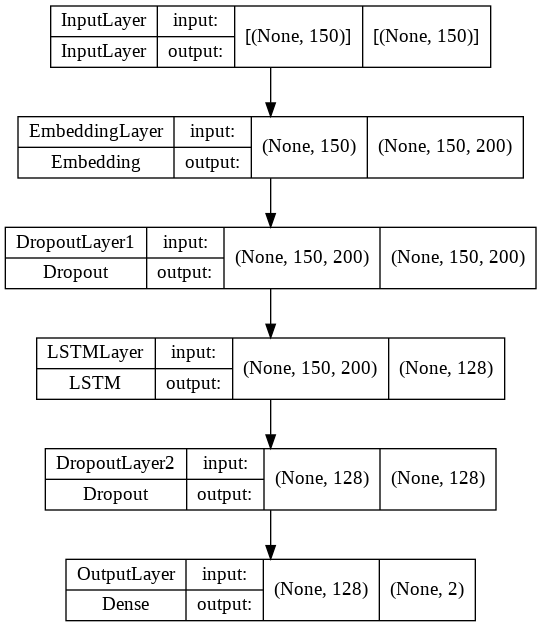

In [ ]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(lstm_glv_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the LSTM Model**

The model gets compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minima which will then start decaying exponentially in order to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_glv.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.0001 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_glv_model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_glv_history = lstm_glv_model.fit(X_train_glv, y_train_glv, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/250
27/27 [==============================] - 3s 35ms/step - loss: 0.7015 - acc: 0.5266 - val_loss: 0.6813 - val_acc: 0.5393
Epoch 2/250
27/27 [==============================] - 0s 14ms/step - loss: 0.6815 - acc: 0.5750 - val_loss: 0.6656 - val_acc: 0.5759
Epoch 3/250
27/27 [==============================] - 0s 12ms/step - loss: 0.6579 - acc: 0.6118 - val_loss: 0.6540 - val_acc: 0.5969
Epoch 4/250
27/27 [==============================] - 0s 12ms/step - loss: 0.6481 - acc: 0.6211 - val_loss: 0.6461 - val_acc: 0.6283
Epoch 5/250
27/27 [==============================] - 0s 12ms/step - loss: 0.6279 - acc: 0.6684 - val_loss: 0.6336 - val_acc: 0.6440
Epoch 6/250
27/27 [==============================] - 0s 12ms/step - loss: 0.6115 - acc: 0.6673 - val_loss: 0.6119 - val_acc: 0.6597
Epoch 7/250
27/27 [==============================] - 0s 12ms/step - loss: 0.5824 - acc: 0.7034 - val_loss: 0.5921 - val_acc: 0.6806
Epoch 8/250
27/27 [==============================] - 0s 12ms/step - loss: 0.

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

Load the training and validation accuracy and loss from the training history

In [ ]:
# Load the history dictionary
lstm_glv_hist_dict = lstm_glv_history.history
# Store the performance metrics
lstm_glv_acc = lstm_glv_hist_dict['acc'] # Accuracy
lstm_glv_val_acc = lstm_glv_hist_dict['val_acc'] # Validation Accuracy
lstm_glv_loss = lstm_glv_hist_dict['loss'] # Loss
lstm_glv_val_loss = lstm_glv_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_glv_acc) + 1)

Plot training and validation loss

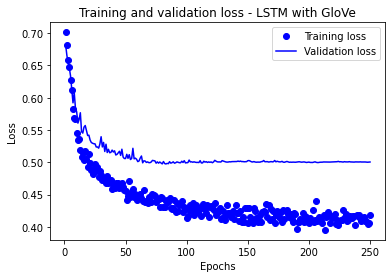

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_glv_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_glv_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

Plot training and validation accuracy

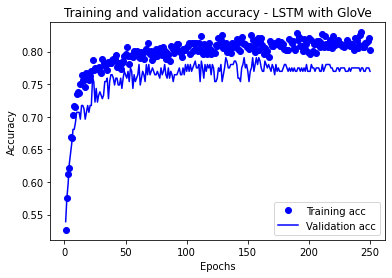

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_glv_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_glv_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 5ms/step - loss: 0.5262 - acc: 0.7411
Model Loss, Model Accuracy: [0.5261818170547485, 0.7410526275634766]
GloVe F1 Score: 0.7421383647798742


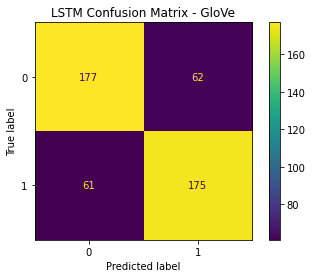

In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
lstm_glv_results = lstm_glv_model.evaluate(X_test_glv, y_test_glv)
print("Model Loss, Model Accuracy:", lstm_glv_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
lstm_glv_pred = lstm_glv_model.predict(X_test_glv)
# Convert pred to boolean
y_pred_bool_glv = np.argmax(lstm_glv_pred, axis=1)
# Convert the categorical label to numeric
y_test_lstm_glv_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('GloVe F1 Score: '+str(f1_score(y_test_lstm_glv_num, y_pred_bool_glv, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_lstm_glv_num, y_pred_bool_glv) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('LSTM Confusion Matrix - GloVe') # Set Title
# Show the plot
plt.show()

Using the Pre-Trained GloVe word embeddings did not affect the performance of the LSTM model, compared to using and training the randomly initialised word embeddings. This is proof that the LSTM model does a good job at keeping and remembering useful information and training the randomised word embeddings for the specific task of hate speech detection.

### Context Independent Word Embeddings - Word2Vec
The Word2Vec method was introduced in (Mikolov, Yih and Zweig, 2013) as an attempt to make the neural-network-based training of the embedding more efficient. Instead of representing words as a word count, the model learns and represents the words’ relationships by placing them in a continuous vector space. As stated by Mikolov, Yih, and Zweig in their paper, “We find that these representations are surprisingly good at capturing syntactic and semantic regularities in language and that each relationship is characterized by a relation-specific vector offset. This allows vector-oriented reasoning based on the offsets between words.”

#### Create a vocabulary index

The first step is to index the vocabulary found in the dataset, by using Keras' Tokenizer.

In [ ]:
# Set max sentence length to 150
max_sent_len = 150
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to True
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

Get a dictionary with each word to its index.

In [ ]:
# Get word index
word_idx = tokenizer.word_index

Checking that the dictionary works, using a test sentence. 

In [ ]:
test = ["i", "like", "every", "person", "in", "the", "world"]
[word_idx[w] for w in test]

[6, 32, 95, 164, 8, 2, 147]

#### Load the Word2Vec pre-trained word embeddings

Download the Pre-trained word and phrase vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.

In [ ]:
# Download pre-trained vectors from gensim
#import gensim.downloader
#w2v_vectors = gensim.downloader.load('word2vec-google-news-300')  # load pre-trained word-vectors from gensim-data

# Copy glove file from drive to local machine
!cp -r /content/drive/MyDrive/Colab_Notebooks/word2vec-google-news-300.gz /content/data

In [ ]:
# Load vectors directly from the file
w2v_vectors = KeyedVectors.load_word2vec_format('word2vec-google-news-300.gz', binary=True)

The next step is to create a corresponding embedding matrix that can be used in the Keras Embedding layer. Entry at index i is the pre-trained vector for the word of index i in the vectorizer's vocabulary.

In [ ]:
# Embedding matrix for keras embedding layer
embedding_dim = 300 # dimension of word2vec vectors used
num_tokens = len(word_idx) + 1

# Create the embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# Go through every word in the word/idx dictionary
for word, i in word_idx.items():
    # Get word's vector representation from the w2v vectors
    try: # If vector is not none (the word exists)
      embedding_vector = w2v_vectors.get_vector(word)
      # Store word's index and its vector representation
      embedding_matrix[i] = embedding_vector
    except:
        pass

Check how many words from the vocabulary are not found in the pre-trained vectors.

In [ ]:
# Counter for missing words
missing_words = 0
# For every word_vector in the matrix
for word_vector in embedding_matrix:
  # If the mean is zero
  if word_vector.mean() == 0:
    missing_words+=1 # Counter
# Show number of missing words minus 1 for the OOV token
print(str(missing_words - 1) + " words from the vocabulary are missing from the Pre-Trained Word2Vec vectors.")

494 words from the vocabulary are missing from the Pre-Trained Word2Vec vectors.


The matrix can now be loaded into a Keras Embedding layer, with the trainable flag equal to False, so that it won't get updated during the training.

#### Prepare the train and test subsets for training

First, the list-of-strings data must be converted to NumPy arrays of integer indices.

In [ ]:
# Convert train subset to list of sequences
X_train_w2v = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_sent_len, dtype='int64',
                            padding='pre')

# Convert test to sequences
X_test_w2v = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_sent_len, dtype='int64',
                           padding='pre')



# one hot encode train labels
y_train_w2v = pd.get_dummies(train_df.label).values.astype('int64')
# Convert the categorical label to numeric
y_train_w2v_num = train_df.label.replace(['hate','noHate'],[0,1])

# one hot encode test labels
y_test_w2v = pd.get_dummies(test_df.label).values.astype('int64')
# Convert the categorical label to numeric
y_test_w2v_num = test_df.label.replace(['hate','noHate'],[0,1])

#### Test the Support Vector Machine Model with the Word2Vec embeddings

**Map the embedding matrix vectors to the train and test data**

Unlike the Keras Deep Learning Networks, the Scikit-learn LinearSVC model does not incorporate an embedding layer. Therefore, the mapping to the train and test data has to be applied manually.

In [ ]:
# Initialize empty lists for train and test data
X_train_svm_w2v = []
X_test_svm_w2v = []

# Map embedding matrix to the train subset
for sent_array in X_train_w2v: # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_train_svm_w2v.append(temp_list)
# Transform to numpy array
X_train_svm_w2v = np.asarray(X_train_svm_w2v, dtype='float64')
# Reshape from 3D to 2D to feed in SVM
X_train_svm_w2v = X_train_svm_w2v.reshape(X_train_w2v.shape[-2],-1)

# Map embedding matrix to the test subset
for sent_array in X_test_w2v: # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_test_svm_w2v.append(temp_list)
# Transform to numpy array
X_test_svm_w2v = np.asarray(X_test_svm_w2v, dtype='float64')
# Reshape from 3D to 2D to feed in SVM
X_test_svm_w2v = X_test_svm_w2v.reshape(X_test_w2v.shape[-2],-1)

Create and train the SVM model

In [ ]:
# Instatiate SVC
svm_w2v = LinearSVC(C=0.0006)
# Fit training data
svm_w2v.fit(X_train_svm_w2v, y_train_w2v_num)
# Get prediction on test data
svm_w2v_pred = svm_w2v.predict(X_test_svm_w2v)

Get Accuracy, F1 Score, and Confusion Matrix

Accuracy: 0.6884210526315789
F1 Score: 0.6864406779661016


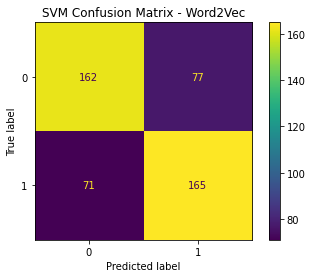

In [ ]:
# Print the accuracy
print('Accuracy: '+str(svm_w2v.score(X_test_svm_w2v, y_test_w2v_num)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_w2v_num, svm_w2v_pred, pos_label=0)))
# Create confusion matrix
cm = confusion_matrix(y_test_w2v_num, svm_w2v_pred, labels=svm_w2v.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_w2v.classes_)
disp.plot()
plt.title('SVM Confusion Matrix - Word2Vec')
plt.show()

Similarly to the experiment with GloVe vectors, using Word2Vec embeddings with SVM negatively affected the performance slightly, compared to using the traditional Bag-of-Words method. These results make sense since simpler models like SVM, cannot handle three-dimensional data like Deep Learning Neural Networks. The data had to be reshaped to two-dimensional, losing the spatial features of the Word2Vec vectors. The results compared to the GloVe vectors are slightly worse since more vocabulary words are missing from the Word2Vec vectors (494), compared to the GloVe vectors (313). 

#### Test the Convolutional Neural Network Model with the Word2Vec embeddings

Set up hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 250

Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_w2v.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_w2v.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with Word2Vec word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_w2v_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_w2v_model.summary()

Sequence Length: 150
Input Shape: (150,)
Vocabulary Size: 5549
Embedding Size: 300
Number of Classes: 2
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 150, 300)     1664700     ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 150, 300)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 148, 100)     90100       ['DropoutLayer1[0][0]'

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

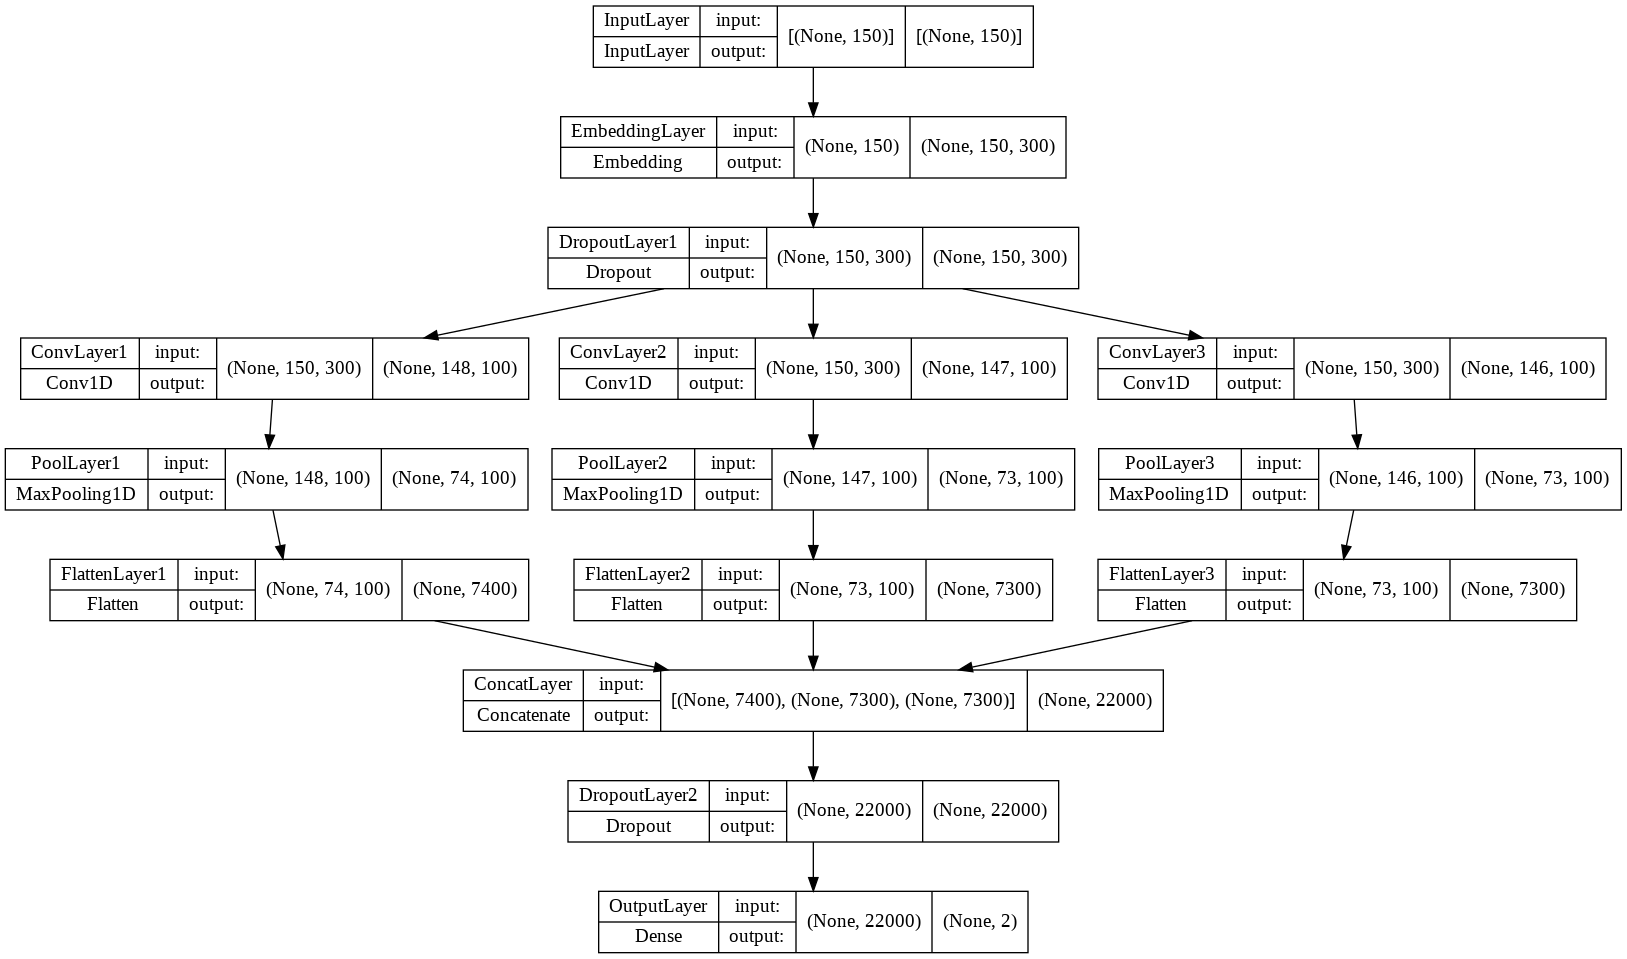

In [ ]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(cnn_w2v_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the CNN Model**

The model gets compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minima which will then start decaying exponentially in order to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_w2v.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.00005 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_w2v_model.compile(optimizer=Adam(learning_rate = lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_w2v_history = cnn_w2v_model.fit(X_train_w2v, y_train_w2v, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/250
27/27 [==============================] - 1s 20ms/step - loss: 0.6939 - acc: 0.5166 - val_loss: 0.6867 - val_acc: 0.4921
Epoch 2/250
27/27 [==============================] - 0s 11ms/step - loss: 0.6782 - acc: 0.5604 - val_loss: 0.6808 - val_acc: 0.5654
Epoch 3/250
27/27 [==============================] - 0s 10ms/step - loss: 0.6693 - acc: 0.6223 - val_loss: 0.6748 - val_acc: 0.6178
Epoch 4/250
27/27 [==============================] - 0s 10ms/step - loss: 0.6633 - acc: 0.6328 - val_loss: 0.6703 - val_acc: 0.6230
Epoch 5/250
27/27 [==============================] - 0s 10ms/step - loss: 0.6580 - acc: 0.6527 - val_loss: 0.6652 - val_acc: 0.6492
Epoch 6/250
27/27 [==============================] - 0s 10ms/step - loss: 0.6477 - acc: 0.6579 - val_loss: 0.6606 - val_acc: 0.6387
Epoch 7/250
27/27 [==============================] - 0s 10ms/step - loss: 0.6426 - acc: 0.6696 - val_loss: 0.6566 - val_acc: 0.6387
Epoch 8/250
27/27 [==============================] - 0s 10ms/step - loss: 0.

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

Load the training and validation accuracy and loss from the training history

In [ ]:
# Load the history dictionary
cnn_w2v_hist_dict = cnn_w2v_history.history
# Store the performance metrics
cnn_w2v_acc = cnn_w2v_hist_dict['acc'] # Accuracy
cnn_w2v_val_acc = cnn_w2v_hist_dict['val_acc'] # Validation Accuracy
cnn_w2v_loss = cnn_w2v_hist_dict['loss'] # Loss
cnn_w2v_val_loss = cnn_w2v_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_w2v_acc) + 1)

Plot training and validation loss

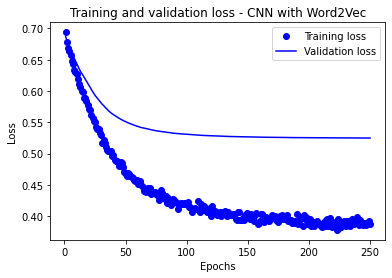

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_w2v_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_w2v_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

Plot training and validation accuracy

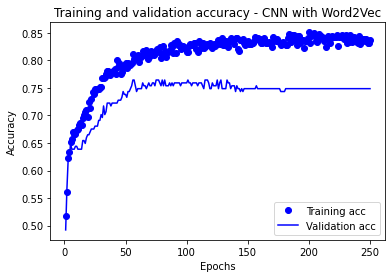

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_w2v_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_w2v_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 4ms/step - loss: 0.5865 - acc: 0.6905
Model Loss, Model Accuracy: [0.5864795446395874, 0.6905263066291809]
Word2Vec F1 Score: 0.6278481012658227


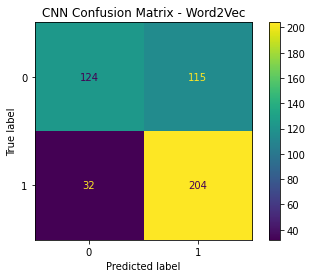

In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
cnn_w2v_results = cnn_w2v_model.evaluate(X_test_w2v, y_test_w2v)
print("Model Loss, Model Accuracy:", cnn_w2v_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
cnn_w2v_pred = cnn_w2v_model.predict(X_test_w2v)
# Convert pred to boolean
y_pred_bool_w2v = np.argmax(cnn_w2v_pred, axis=1)
# Convert the categorical label to numeric
y_test_cnn_w2v_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('Word2Vec F1 Score: '+str(f1_score(y_test_cnn_w2v_num, y_pred_bool_w2v, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_cnn_w2v_num, y_pred_bool_w2v) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('CNN Confusion Matrix - Word2Vec') # Set Title
# Show the plot
plt.show()

As expected, the model's results using Word2Vec word embeddings were worse than the results of the model that used GloVe word embeddings, with further missclassifications of the Hate speech class. The reason behind this is that Word2Vec has fewer word representations in our corpus, with 494 vocabulary words missing from the embedding matrix, making the model unable to capture the unique patterns that define the Hate speech class.

#### Test the Long Short-Term Memory Model with the Word2Vec embeddings

Set up hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 250

Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_w2v.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_w2v.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Embedding Layer with Word2Vec word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_w2v_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_w2v_model.summary()

Sequence Length: 150
Input Shape: (150,)
Vocabulary Size: 5549
Embedding Size: 300
Number of Classes: 2
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 150)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 150, 300)          1664700   
                                                                 
 DropoutLayer1 (Dropout)     (None, 150, 300)          0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               219648    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                     

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

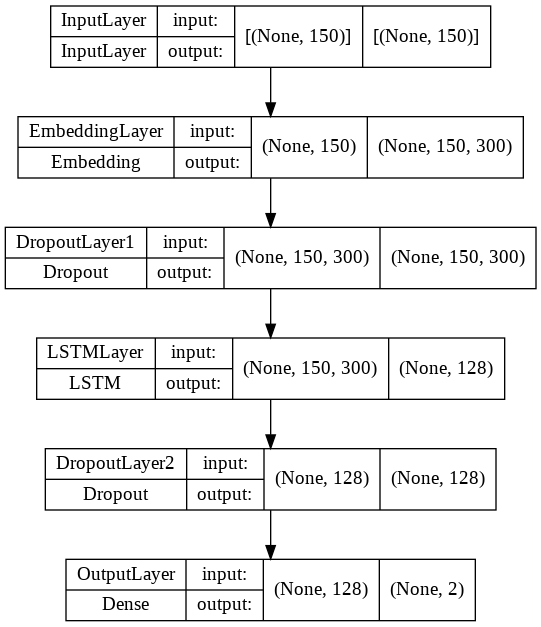

In [ ]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(lstm_w2v_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the LSTM Model**

The model gets compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minima which will then start decaying exponentially in order to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_w2v.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.0001 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_w2v_model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_w2v_history = lstm_w2v_model.fit(X_train_w2v, y_train_w2v, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/250
27/27 [==============================] - 4s 37ms/step - loss: 0.6975 - acc: 0.5143 - val_loss: 0.6871 - val_acc: 0.5550
Epoch 2/250
27/27 [==============================] - 0s 14ms/step - loss: 0.6796 - acc: 0.5581 - val_loss: 0.6761 - val_acc: 0.5707
Epoch 3/250
27/27 [==============================] - 0s 14ms/step - loss: 0.6614 - acc: 0.6217 - val_loss: 0.6583 - val_acc: 0.6230
Epoch 4/250
27/27 [==============================] - 0s 14ms/step - loss: 0.6327 - acc: 0.6789 - val_loss: 0.6257 - val_acc: 0.6702
Epoch 5/250
27/27 [==============================] - 0s 14ms/step - loss: 0.5965 - acc: 0.7075 - val_loss: 0.6071 - val_acc: 0.6754
Epoch 6/250
27/27 [==============================] - 0s 14ms/step - loss: 0.5793 - acc: 0.7093 - val_loss: 0.5875 - val_acc: 0.7120
Epoch 7/250
27/27 [==============================] - 0s 14ms/step - loss: 0.5588 - acc: 0.7367 - val_loss: 0.5780 - val_acc: 0.6963
Epoch 8/250
27/27 [==============================] - 0s 14ms/step - loss: 0.

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

Load the training and validation accuracy and loss from the training history

In [ ]:
# Load the history dictionary
lstm_w2v_hist_dict = lstm_w2v_history.history
# Store the performance metrics
lstm_w2v_acc = lstm_w2v_hist_dict['acc'] # Accuracy
lstm_w2v_val_acc = lstm_w2v_hist_dict['val_acc'] # Validation Accuracy
lstm_w2v_loss = lstm_w2v_hist_dict['loss'] # Loss
lstm_w2v_val_loss = lstm_w2v_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_w2v_acc) + 1)

Plot training and validation loss

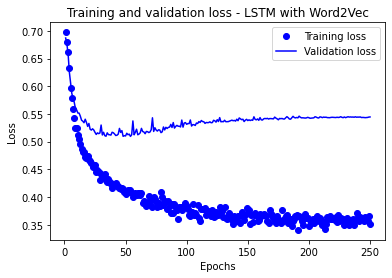

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_w2v_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_w2v_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

Plot training and validation accuracy

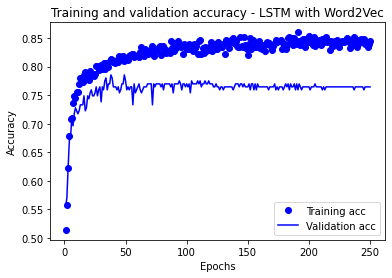

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_w2v_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_w2v_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 0s 6ms/step - loss: 0.7008 - acc: 0.7074
Model Loss, Model Accuracy: [0.7008374929428101, 0.7073684334754944]
Word2Vec F1 Score: 0.65679012345679


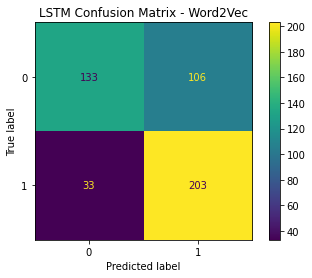

In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
lstm_w2v_results = lstm_w2v_model.evaluate(X_test_w2v, y_test_w2v)
print("Model Loss, Model Accuracy:", lstm_w2v_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
lstm_w2v_pred = lstm_w2v_model.predict(X_test_w2v)
# Convert pred to boolean
y_pred_bool_w2v = np.argmax(lstm_w2v_pred, axis=1)
# Convert the categorical label to numeric
y_test_lstm_w2v_num = test_df.label.replace(['hate','noHate'],[0,1])

# Print the F1 Score
print('Word2Vec F1 Score: '+str(f1_score(y_test_lstm_w2v_num, y_pred_bool_w2v, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_lstm_w2v_num, y_pred_bool_w2v) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('LSTM Confusion Matrix - Word2Vec') # Set Title
# Show the plot
plt.show()

Similarly to the Word2Vec CNN model's results, the Word2Vec LSTM model performed worse overall than the GloVe LSTM model. Although more No Hate sentences were correctly classified, the Word2Vec LSTM model's ability to correctly identify the Hate sentences decreased significantly, thus making the Word2Vec word embeddings unfit for this specific classification task.

### Context Dependent Word Embeddings - ELMo

### Context Dependent Word Embeddings - BERT

Bidirectional Encoder Representations from Transformers, or BERT for short, is a pre-trained Transformer based deep learning model introduced in (Devlin et al., 2019), in which every output element is connected to every input element. The weights between the elements are dynamically calculated based on their connection. One of the main differences compared to the other methods is that the output of BERT also includes the model together with the vectors. As stated by Devlin et al. in their paper, “the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications”.


**The BERT model can be used in three different ways:**
1. It can be trained completely from scratch and used as a classifier itself
2. Its pre-trained word embeddings can be extracted and used in a Keras embedding layer, similar to the way GloVe and Word2Vec embeddings were used above
3. A pre-trained model can be fine tuned using its output as input for a Deep Learning model

The purpose of this research is to determine whether the use of different input methods, like pre-trained contextualised word embeddings, improve or worsen a model's performance in text classification tasks. Therefore, a pre-trained BERT model will be fine tuned and used as input for the above Deep Learning models. This is also known as Transfer Learning. The model that will be used is the BASE BERT model.

#### Format the input and prepare the dataset
Because a pre-trained BERT model will be used, the data needs to be transformed in a format that BERT recognises and was trained on. More specifically, BERT requires:
- A special **seperator [SEP]** token that marks the end of a sentence or the seperation between two sentences
- A special **class [CLS]** token at the beginning of each text, used for classification tasks
- Tokens that comply with BERT's fixed vocabulary
- The **Token IDs** from BERT's tokenizer
- The **Mask IDs** to distinguish tokens from padding elements
- The **Segment IDs** to distinguish different sentences
- The **Positional Embeddings** that show each token's position within the sentence

All of the above requirements can be taken care of by using the tokenizer.encode_plus function from the transformers package.

**Tokenize Text according to BERT's requirements**

First, the Bert Tokenizer is loaded from the pre-trained BASE model.

In [203]:
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding_side = 'left')

Prepare the Train and Test subsets so that they can be fed to the BERT model.

In [204]:
# Set max sentence length to 150 as before
max_sent_len = 150

# Prepare the Train subset
tr_input_ids = [] # encoded sentence list
tr_masks = [] # attention mask list
# For every sentence in the train dataframe
for sent in train_df.clean_sentence.to_list():
  tr_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate sentences
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad sentences
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  tr_input_ids.append(tr_enc_dict['input_ids'])
  # Add the attention mask
  tr_masks.append(tr_enc_dict['attention_mask'])

# Train feature matrix
#X_train_bert = [np.array(tr_input_ids), np.array(tr_masks)]
tr_input_ids = np.array(tr_input_ids)
tr_masks = np.array(tr_masks)

# Prepare the Test subset
ts_input_ids = [] # encoded sentence list
ts_masks = [] # attention mask list
# For every sentence in the test dataframe
for sent in test_df.clean_sentence.to_list():
  ts_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate sentences
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad sentences
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  ts_input_ids.append(ts_enc_dict['input_ids'])
  # Add the attention mask
  ts_masks.append(ts_enc_dict['attention_mask'])

# Test feature matrix
#X_test_bert = [np.array(ts_input_ids), np.array(ts_masks)]
ts_input_ids = np.array(ts_input_ids)
ts_masks = np.array(ts_masks)

# one hot encode train labels
y_train_bert = pd.get_dummies(train_df.label).values.astype('int64')
# Convert the categorical label to numeric
y_train_bert_num = train_df.label.replace(['hate','noHate'],[0,1])

# one hot encode test labels
y_test_bert = pd.get_dummies(test_df.label).values.astype('int64')
# Convert the categorical label to numeric
y_test_bert_num = test_df.label.replace(['hate','noHate'],[0,1])

#### Load the Pre-Trained BERT model
The pre-trained BASE BERT model will be used. The BASE model is a smaller version which has 12 transformer blocks, a hidden layer size of 768, and 12 attention heads. Since BERT is used only for its "raw" output, it will not be fine-tuned. This can be achieved by freezing its weights and setting trainable equal to False.

In [205]:
# Load the pre-trained model
bert_trained = TFBertModel.from_pretrained('bert-base-uncased')
# Freeze the weights
bert_trained.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Test the Support Vector Machine Model with the BERT embeddings

Pass the Train and Test data through BERT and get its embeddings to use as input for SVM

In [421]:
# Training Data
X_train_svm_bert = bert_trained.bert.embeddings(tr_input_ids,tr_masks).numpy()
# Reshape Training Data
X_train_svm_bert = X_train_svm_bert.reshape(X_train_svm_bert.shape[0],-1)

# Test Data
X_test_svm_bert = bert_trained.bert.embeddings(ts_input_ids,ts_masks).numpy()
# Reshape Test Data
X_test_svm_bert = X_test_svm_bert.reshape(X_test_svm_bert.shape[0],-1)

Create and train the SVM model

In [423]:
# Instatiate SVC
svm_bert = LinearSVC(C=0.0005)
# Fit training data
svm_bert.fit(X_train_svm_bert, y_train_glv_num)
# Get prediction on test data
svm_bert_pred = svm_bert.predict(X_test_svm_bert)

Get Accuracy, F1 Score, and Confusion Matrix

Accuracy: 0.7031578947368421
F1 Score: 0.7128309572301426


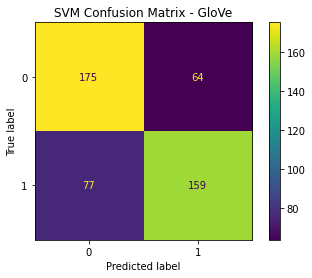

In [424]:
# Print the accuracy
print('Accuracy: '+str(svm_bert.score(X_test_svm_bert, y_test_glv_num)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_glv_num, svm_bert_pred, pos_label=0)))
# Create confusion matrix
cm = confusion_matrix(y_test_glv_num, svm_bert_pred, labels=svm_bert.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_bert.classes_)
disp.plot()
plt.title('SVM Confusion Matrix - BERT')
plt.show()

Using GloVe embeddings with SVM negatively affected the performance slightly, compared to using the traditional Bag-of-Words method. These results make sense since simpler models like SVM, cannot handle three-dimensional data like Deep Learning Neural Networks. The embedding vectors had to be reshaped to maintain the dimensionality that works with SVM, losing the spatial features of the GloVe vectors.

#### Test the Convolutional Neural Network Model with BERT

Set up hyperparameters

In [88]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 10

Build the model

In [89]:
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers with BERT 
# The Custom Input Layer
input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
inputBert = [input_ids, masks] # Input for BERT Model
# The Bert Layer
bert_out = bert_trained(inputBert) # Pass data through Bert
bert_out = bert_out[0] # Get the last hidden layer
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(bert_out) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(bert_out) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(bert_out) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_bert_model = Model(inputBert, outputLayer)
# Print model summary
cnn_bert_model.summary()

Sequence Length: 150
Input Shape: (150,)
Number of Classes: 2
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputIDs (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 MaskIDs (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 tf_bert_model_6 (TFBertModel)  TFBaseModelOutputWi  109482240   ['InputIDs[0][0]',               
                                thPoolingAndCrossAt               'MaskIDs[0][0]']                
                                tentions(last_hidde                                               
                              

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

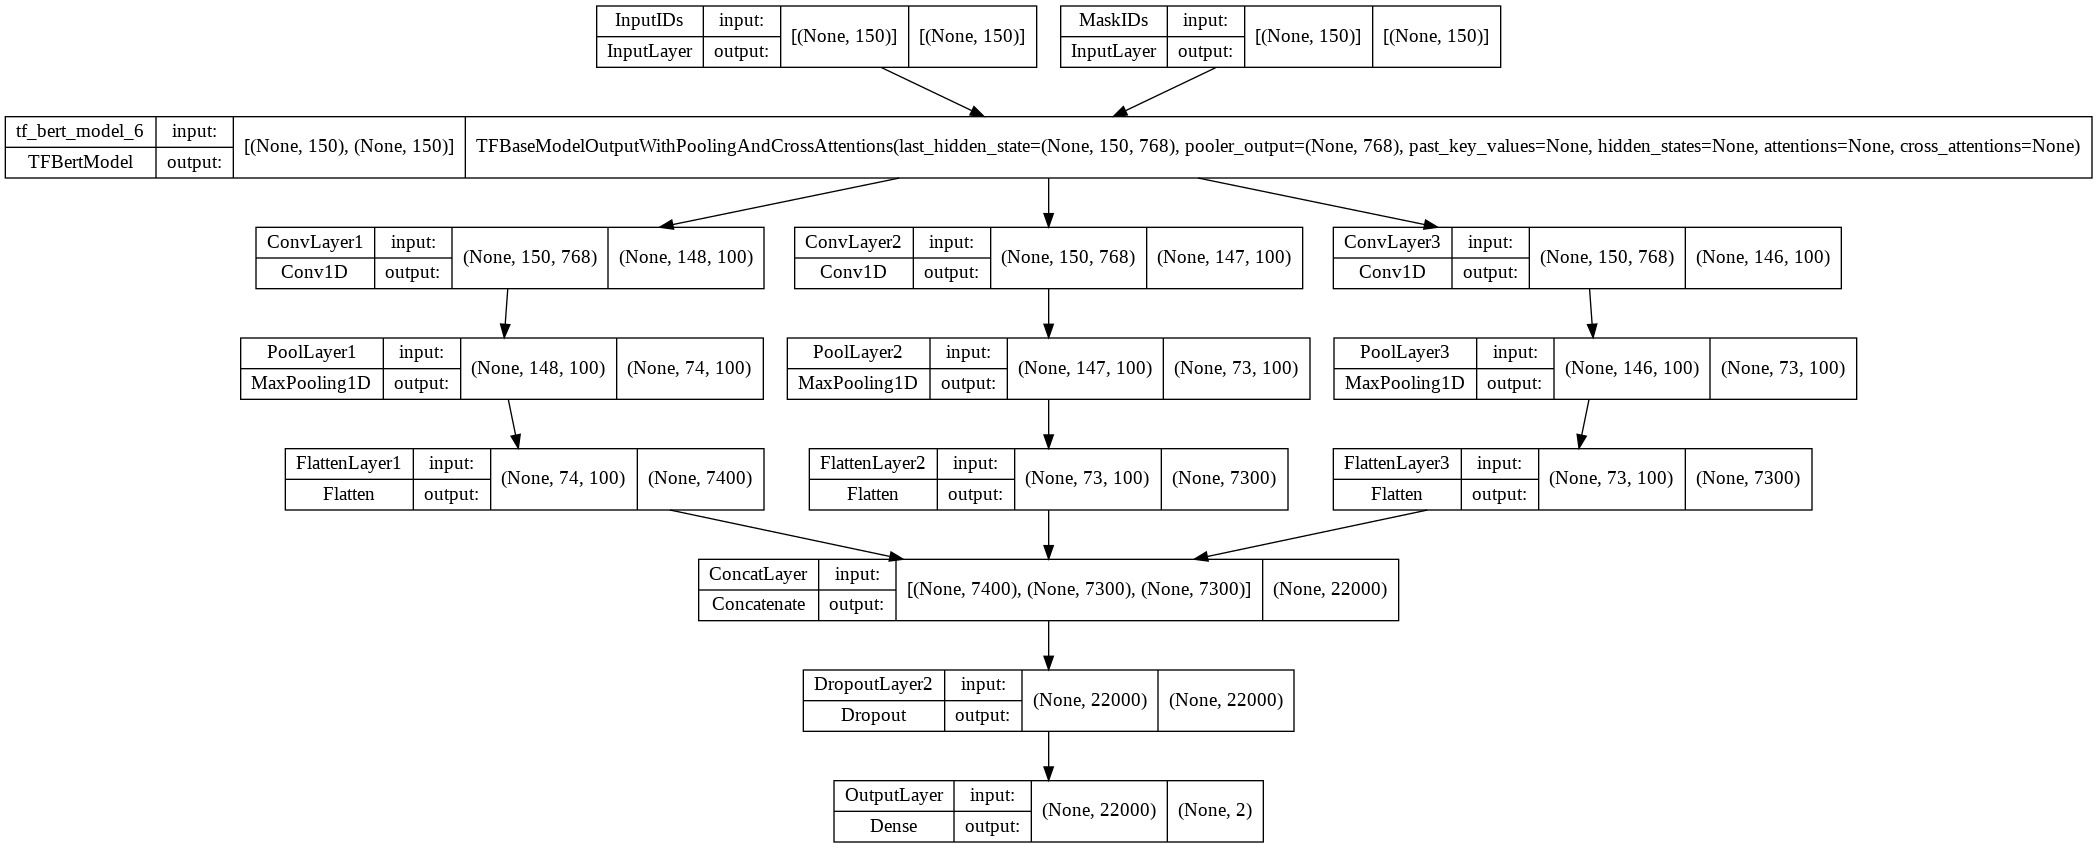

In [90]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(cnn_bert_model, show_shapes=True, show_layer_names=True)

**Train the CNN Model**

The model gets compiled choosing Adam with weight decay (AdamW) as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.


In [91]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_bert_model.compile(optimizer=AdamW(weight_decay=0.001, learning_rate=0.00006),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_bert_history = cnn_bert_model.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/10
27/27 [==============================] - 29s 575ms/step - loss: 0.6137 - acc: 0.6538 - val_loss: 0.5162 - val_acc: 0.7382
Epoch 2/10
27/27 [==============================] - 12s 464ms/step - loss: 0.4932 - acc: 0.7572 - val_loss: 0.4920 - val_acc: 0.7592
Epoch 3/10
27/27 [==============================] - 13s 465ms/step - loss: 0.4542 - acc: 0.7828 - val_loss: 0.4985 - val_acc: 0.7644
Epoch 4/10
27/27 [==============================] - 12s 464ms/step - loss: 0.4055 - acc: 0.8184 - val_loss: 0.4805 - val_acc: 0.7644
Epoch 5/10
27/27 [==============================] - 12s 464ms/step - loss: 0.3936 - acc: 0.8272 - val_loss: 0.5089 - val_acc: 0.7592
Epoch 6/10
27/27 [==============================] - 12s 464ms/step - loss: 0.3676 - acc: 0.8395 - val_loss: 0.5720 - val_acc: 0.7016
Epoch 7/10
27/27 [==============================] - 13s 465ms/step - loss: 0.3589 - acc: 0.8465 - val_loss: 0.4685 - val_acc: 0.7958
Epoch 8/10
27/27 [==============================] - 13s 465ms/step - 

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

Load the training and validation accuracy and loss from the training history

In [92]:
# Load the history dictionary
cnn_bert_hist_dict = cnn_bert_history.history
# Store the performance metrics
cnn_bert_acc = cnn_bert_hist_dict['acc'] # Accuracy
cnn_bert_val_acc = cnn_bert_hist_dict['val_acc'] # Validation Accuracy
cnn_bert_loss = cnn_bert_hist_dict['loss'] # Loss
cnn_bert_val_loss = cnn_bert_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_bert_acc) + 1)

Plot training and validation loss

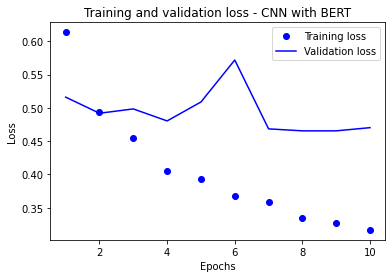

In [93]:
# Training and validation loss
plt.plot(epochs, cnn_bert_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_bert_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN with BERT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

Plot training and validation accuracy

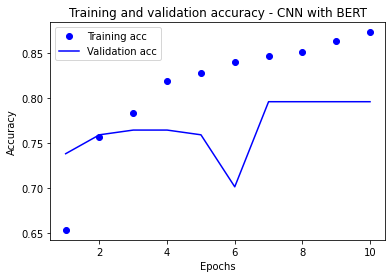

In [94]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_bert_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_bert_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN with BERT')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 3s 215ms/step - loss: 0.4607 - acc: 0.7811
Model Loss, Model Accuracy: [0.4606654644012451, 0.7810526490211487]
BERTCNN F1 Score: 0.7851239669421488


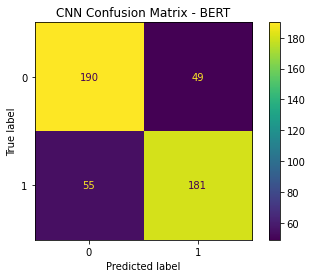

In [95]:
# Evaluate the model on the test subset
print("Evaluate on test data")
cnn_bert_results = cnn_bert_model.evaluate([ts_input_ids,ts_masks], y_test_bert)
print("Model Loss, Model Accuracy:", cnn_bert_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
cnn_bert_pred = cnn_bert_model.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert = np.argmax(cnn_bert_pred, axis=1)

# Print the F1 Score
print('BERTCNN F1 Score: '+str(f1_score(y_test_bert_num, y_pred_bool_bert, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('CNN Confusion Matrix - BERT') # Set Title
# Show the plot
plt.show()

Using BERT's last hidden layer as input for the CNN greatly improved its performance, returning an overall accuracy of 0.78 and an F1 Score of 0.79 on the Hate class, outperforming all the other variations of the CNN model. The model also required much less epochs to train, which is one of the advantages of BERT and Transfer Learning.

#### Test the Long Short-Term Memory Model with BERT

Set up hyperparameters

In [338]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 15

Build the model

In [339]:
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers with BERT 
# The Custom Input Layer
input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
inputBert = [input_ids, masks] # Input for BERT Model
# The Bert Layer
bert_out = bert_trained(inputBert) # Pass data through Bert
bert_out = bert_out[0] # Get the last hidden layer
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(bert_out)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_bert_model = Model(inputBert, outputLayer)
# Print model summary
lstm_bert_model.summary()

Sequence Length: 150
Input Shape: (150,)
Number of Classes: 2
Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputIDs (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 MaskIDs (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 tf_bert_model_7 (TFBertModel)  TFBaseModelOutputWi  109482240   ['InputIDs[0][0]',               
                                thPoolingAndCrossAt               'MaskIDs[0][0]']                
                                tentions(last_hidde                                               
                             

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers order and shapes.

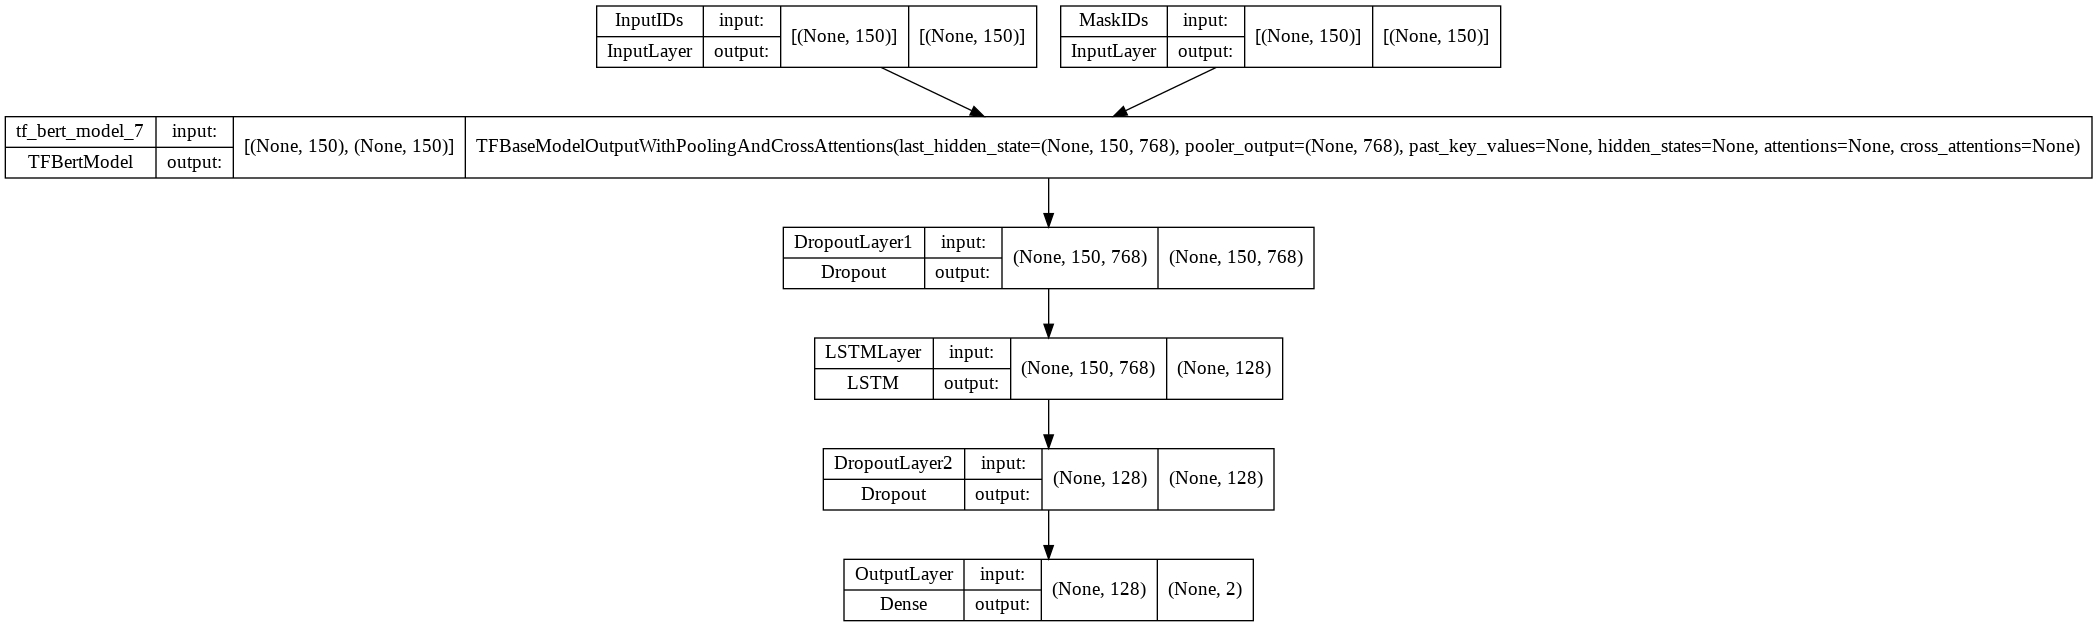

In [340]:
# Import visualisation library
from keras.utils.vis_utils import plot_model
# Plot the model
plot_model(lstm_bert_model, show_shapes=True, show_layer_names=True)

**Train the LSTM Model**

The model gets compiled choosing Adam with weight decay (AdamW) as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

In [341]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_bert_model.compile(optimizer=AdamW(weight_decay=0.001, learning_rate=0.00005),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_bert_history = lstm_bert_model.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/15
27/27 [==============================] - 31s 597ms/step - loss: 0.6667 - acc: 0.5884 - val_loss: 0.6192 - val_acc: 0.6911
Epoch 2/15
27/27 [==============================] - 13s 466ms/step - loss: 0.6109 - acc: 0.6772 - val_loss: 0.5725 - val_acc: 0.7644
Epoch 3/15
27/27 [==============================] - 13s 469ms/step - loss: 0.5685 - acc: 0.7233 - val_loss: 0.5418 - val_acc: 0.7696
Epoch 4/15
27/27 [==============================] - 13s 467ms/step - loss: 0.5279 - acc: 0.7461 - val_loss: 0.5138 - val_acc: 0.7644
Epoch 5/15
27/27 [==============================] - 13s 466ms/step - loss: 0.5027 - acc: 0.7624 - val_loss: 0.5047 - val_acc: 0.7539
Epoch 6/15
27/27 [==============================] - 13s 466ms/step - loss: 0.4815 - acc: 0.7834 - val_loss: 0.4868 - val_acc: 0.7539
Epoch 7/15
27/27 [==============================] - 13s 466ms/step - loss: 0.4615 - acc: 0.7840 - val_loss: 0.4676 - val_acc: 0.7487
Epoch 8/15
27/27 [==============================] - 13s 466ms/step - 

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

Load the training and validation accuracy and loss from the training history

In [342]:
# Load the history dictionary
lstm_bert_hist_dict = lstm_bert_history.history
# Store the performance metrics
lstm_bert_acc = lstm_bert_hist_dict['acc'] # Accuracy
lstm_bert_val_acc = lstm_bert_hist_dict['val_acc'] # Validation Accuracy
lstm_bert_loss = lstm_bert_hist_dict['loss'] # Loss
lstm_bert_val_loss = lstm_bert_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_bert_acc) + 1)

Plot training and validation loss

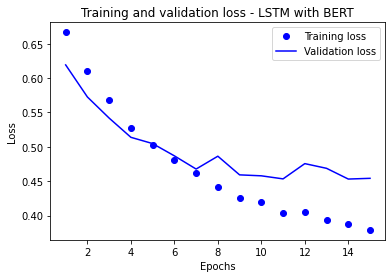

In [343]:
# Training and validation loss
plt.plot(epochs, lstm_bert_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_bert_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM with BERT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

Plot training and validation accuracy

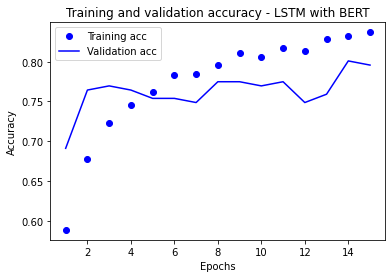

In [344]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_bert_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_bert_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM with BERT')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the accuracy, F1 Score and Confusion Matrix metrics.

Evaluate on test data
15/15 [==============================] - 3s 219ms/step - loss: 0.4600 - acc: 0.8063
Model Loss, Model Accuracy: [0.46004095673561096, 0.8063157796859741]
BERTLSTM F1 Score: 0.8075313807531381


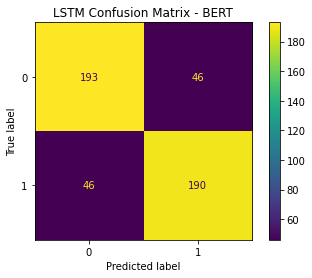

In [345]:
# Evaluate the model on the test subset
print("Evaluate on test data")
lstm_bert_results = lstm_bert_model.evaluate([ts_input_ids,ts_masks], y_test_bert)
print("Model Loss, Model Accuracy:", lstm_bert_results)

# Store the predictions to be used for the F1 Score and the Confusion Matrix
lstm_bert_pred = lstm_bert_model.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert = np.argmax(lstm_bert_pred, axis=1)

# Print the F1 Score
print('BERTLSTM F1 Score: '+str(f1_score(y_test_bert_num, y_pred_bool_bert, pos_label=0)))

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Generate CM Display
disp.plot()
plt.title('LSTM Confusion Matrix - BERT') # Set Title
# Show the plot
plt.show()

**TO WRITE RESULTS**

In [347]:
# Load the pre-trained model
bert_emb = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# Freeze the weights
bert_emb.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [357]:
bert_emb

In [353]:
emb